<h2 style="text-align:center;margin-bottom:1em;">Прогнозирование рейтинга отеля на Booking</h1>
Представьте, что вы работаете датасаентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов нахождения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель играет нечестно, и его стоит проверить.
Чтобы не вспоминать описание полей данных, приведем их в виде таблицы.
<div style="margin-top:1em;">
    
<table style="width:auto;margin-left:auto;margin-right:auto;">
   <tr>
    <th>Признак</th>
    <th>Описание</th>
  </tr>
  
   <tr>
    <td>hotel_address</td>
    <td>street, post code, city, country </td>
  </tr>
  
  <tr>
    <td>review_date</td>
    <td>the day of review </td>
  </tr>
      
  <tr>
    <td>average_score</td>
    <td>the average rating of the hotel </td>
  </tr>
  
  <tr>
    <td>hotel_name</td>
    <td>the full name of hotel </td>
  </tr>
    
   <tr>
    <td>reviewer_nationality</td>
    <td>country from which the reviewer came </td>
  </tr>
    
   <tr>
    <td>negative_review </td>
    <td>text of negative review </td>
  </tr> 
   
   <tr>
    <td>review_total_negative_word_counts </td>
    <td>the total number words of negative review </td>
  </tr>  
    
  <tr>
    <td>positive_review</td>
    <td>text of positive review </td>
  </tr> 
    
   <tr>
    <td>review_total_positive_word_counts</td>
    <td>the total number words of positive review </td>
  </tr> 
    
  <tr>
    <td>total_number_of_reviews </td>
    <td>the total number of reviews that the hotel has </td>
  </tr>  
  
  <tr>
    <td>reviewer_score</td>
    <td>the number of reviewer score </td>
  </tr> 
    
  <tr>
    <td>total_number_of_reviews_reviewer_has_given</td>
    <td>the total number of reviews reviewer has given </td>
  </tr> 
    
  <tr>
    <td>tags</td>
    <td>tags that describe purpose of trip,type of room, count of nights of reviewer </td>
  </tr> 
    
   <tr>
    <td>days_since_review</td>
    <td>a difference in the number of days between review date and scrape date</td>
  </tr> 
    
  <tr>
    <td>additional_number_of_scoring</td>
    <td>the number of hotel scores without review </td>
  </tr> 
    
  <tr>
    <td>lat</td>
    <td>latitude coordinate of hotel location </td>
  </tr> 
    
  <tr>
    <td>lng</td>
    <td>longitude coordinate of hotel location </td>
  </tr> 
    
</table>
</div>

In [ ]:
# установка необходимых модулей
!pip install Afinn
!pip install nltk[twitter] 
!pip install seaborn 
!pip install plotly.express
!pip install textblob
!pip install -U scikit-learn
!pip install geopy
!pip install catboost
!pip install pycountry_convert

In [322]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Дополнительные библиотеки
from geopy.geocoders import Nominatim
from geopy.distance import geodesic as GD
import pycountry_convert as pc
import category_encoders as ce # импорт для работы с кодировщиком
import math

# библиотеки для анализа слов
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob, Blobber
from afinn import Afinn

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [323]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [324]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [325]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

В этом блоке объявим функции, которые будем использовать несколько раз по ходу исследования

In [326]:
#уменьшение числа категорий
#параметры:
# df - Датасет
# col - столбец с категориальными данными
# n - ограничение на число категорий

def reduce_categories(df, col, n):
    popular_values = df[col].value_counts().nlargest(n).index
    df[col] = df[col].apply(lambda x: x if x in popular_values else 'Other')
    return df

In [327]:
#построение тепловой карты корреляции признаков
def show_corr(df,columns_list, title, method='pearson'):
    fig, ax = plt.subplots(figsize=(15, 12))
    corr = df[columns_list].corr(method=method).abs()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, 
                annot=True,
                annot_kws={"fontsize":9}, 
                linewidths=0.1, 
                ax=ax, 
                mask=mask, 
                cmap='Blues',
                fmt='.2f')
    ax.set_title(title, fontsize=18)
    plt.show()

Проведем первоначальное знакомство с данными.

In [328]:

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [329]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


Выясним, если среди данных train дубли.

In [330]:
df_train.duplicated().sum()

307

Дубли найдены, осталось их удалить.

In [331]:
df_train.drop_duplicates(inplace=True)

In [332]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [333]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [334]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [335]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = pd.concat([df_test, df_train], sort=False).reset_index(drop=True)

Рассмотрим объединенные данные.

In [336]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

В датасете есть пропуски, а именно, для некоторых отелей отсутствуют географические координаты lat и lng.

In [337]:
display(data.shape[0] - data[(data['lng'].isna()) & (data['lat'].isna())].shape[0])

512163

Легко заметить, что данные отсутствуют парами, т.е. нет отелей, где отсутствовала бы лишь одна координата (долгота или широта). Уж если нет координат, то нет сразу обеих.

<h2>Данные, относящиеся к отелю</h2>

Можно предположить, что среди отелей есть те, у которых совпадают названия, но расположены они при этом в разных городах.

In [338]:
grouped = data.groupby(['hotel_name', 'hotel_address'])['hotel_name'].count()

grouped = grouped.groupby('hotel_name').count().sort_values(ascending=False).head(3)

duplicated_hotel_name = grouped.index[0]
quantity_of_duplicated_names = grouped[0]

display(quantity_of_duplicated_names)

display(data[data['hotel_name'] == duplicated_hotel_name][['hotel_name', 'hotel_address']].value_counts())

3

hotel_name    hotel_address                                             
Hotel Regina  Bergara 2 4 Eixample 08002 Barcelona Spain                    590
              Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria           284
              Via Cesare Correnti 13 Milan City Center 20123 Milan Italy     60
dtype: int64

Среди данных нашлось три отеля с одинаковым названием, но различными адресами. Дадим этим отелям уникальные имена, добавив в конце наименования число

In [339]:
hotels_to_rename = data[data['hotel_name'] == duplicated_hotel_name]['hotel_address'].value_counts()

for i in range(len(hotels_to_rename)):
    address_to_rename = hotels_to_rename.index[i]
    data.loc[(data['hotel_address'] == address_to_rename), 'hotel_name'] = duplicated_hotel_name+' '+str(i)

display(data[data['hotel_name'].str.contains(duplicated_hotel_name)][['hotel_name', 'hotel_address']].value_counts())

hotel_name      hotel_address                                             
Hotel Regina 0  Bergara 2 4 Eixample 08002 Barcelona Spain                    590
Hotel Regina 1  Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria           284
Hotel Regina 2  Via Cesare Correnti 13 Milan City Center 20123 Milan Italy     60
dtype: int64

Выберем признаки, которые относятся к данным отеля. Создадим DataFrame, содержащий только уникальные наименования отелей (с учетом произведенных выше переименований)

In [340]:
hotel_cols = ['hotel_name', 'hotel_address', 'lat', 'lng', 'average_score', 'total_number_of_reviews', 'additional_number_of_scoring']

# Удаляем дубликаты:
hotels_uniq = data[hotel_cols].drop_duplicates().reset_index(drop=True)
display(hotels_uniq.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494 entries, 0 to 1493
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   hotel_name                    1494 non-null   object 
 1   hotel_address                 1494 non-null   object 
 2   lat                           1477 non-null   float64
 3   lng                           1477 non-null   float64
 4   average_score                 1494 non-null   float64
 5   total_number_of_reviews       1494 non-null   int64  
 6   additional_number_of_scoring  1494 non-null   int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 81.8+ KB


None

Выбираем все отели, у которых отсутствуют данные о координатах. Так как координаты отсутствуют парами, то проверку на отсутствие сделаем только по одной координате.

In [341]:
hotels_addr = hotels_uniq[hotels_uniq['lat'].notna() == False].sort_values('hotel_name')
display(hotels_addr)

,hotel_name,hotel_address,lat,lng,average_score,total_number_of_reviews,additional_number_of_scoring
1064,Austria Trend Hotel Schloss Wilhelminenberg Wien,Savoyenstra e 2 16 Ottakring 1160 Vienna Austria,NaN,NaN,8.3,1558,86
343,City Hotel Deutschmeister,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...,NaN,NaN,8.0,675,44
495,Cordial Theaterhotel Wien,Josefst dter Stra e 22 08 Josefstadt 1080 Vien...,NaN,NaN,8.4,422,39
1354,Derag Livinghotel Kaiser Franz Joseph Vienna,Sieveringer Stra e 4 19 D bling 1190 Vienna Au...,NaN,NaN,8.0,1496,115
396,Fleming s Selection Hotel Wien City,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,NaN,NaN,8.3,3672,333
376,Holiday Inn Paris Montmartre,23 Rue Damr mont 18th arr 75018 Paris France,NaN,NaN,8.3,298,21
1484,Hotel Advance,Sep lveda 180 Eixample 08011 Barcelona Spain,NaN,NaN,8.3,156,18
35,Hotel Atlanta,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,NaN,NaN,7.8,2724,214
417,Hotel City Central,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,NaN,NaN,8.6,2923,211
872,Hotel Daniel Vienna,Landstra er G rtel 5 03 Landstra e 1030 Vienna...,NaN,NaN,8.5,1405,101


Для этих отелей попробуем определить координаты, используя библиотеку geocoders

In [342]:
loc = Nominatim(user_agent="GetLoc")
# entering the location name
def hotel_getLoc(hotel_address):
    getLoc = loc.geocode(hotel_address)
    try:
        return pd.Series([getLoc.latitude, getLoc.longitude])
    except:
        return pd.Series([np.nan,np.nan])

hotels_addr[['lat','lng']] = hotels_addr['hotel_address'].apply(hotel_getLoc)
display(hotels_addr)

,hotel_name,hotel_address,lat,lng,average_score,total_number_of_reviews,additional_number_of_scoring
1064,Austria Trend Hotel Schloss Wilhelminenberg Wien,Savoyenstra e 2 16 Ottakring 1160 Vienna Austria,NaN,NaN,8.3,1558,86
343,City Hotel Deutschmeister,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...,NaN,NaN,8.0,675,44
495,Cordial Theaterhotel Wien,Josefst dter Stra e 22 08 Josefstadt 1080 Vien...,NaN,NaN,8.4,422,39
1354,Derag Livinghotel Kaiser Franz Joseph Vienna,Sieveringer Stra e 4 19 D bling 1190 Vienna Au...,NaN,NaN,8.0,1496,115
396,Fleming s Selection Hotel Wien City,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,NaN,NaN,8.3,3672,333
376,Holiday Inn Paris Montmartre,23 Rue Damr mont 18th arr 75018 Paris France,NaN,NaN,8.3,298,21
1484,Hotel Advance,Sep lveda 180 Eixample 08011 Barcelona Spain,NaN,NaN,8.3,156,18
35,Hotel Atlanta,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,NaN,NaN,7.8,2724,214
417,Hotel City Central,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,NaN,NaN,8.6,2923,211
872,Hotel Daniel Vienna,Landstra er G rtel 5 03 Landstra e 1030 Vienna...,NaN,NaN,8.5,1405,101


Ни для одного отеля не удалось определить координаты по адресу.
Можно заметить, что эти отели находятся в Австрии, Франции и Испании. Во всех этих странах алфавит не совпадает с латинским и, возможно, в адресе отсутствуют некоторые специфические символы.
Попробуем в ручном режиме внести некоторые изменения в адреса отелей. Можно попробовать два варианта: внести в адрес отсутствующие символы, используя национальную кодировку, а можно попробовать восстановить адрес, используя латинский алфавит.
Используем второй подход. Для этого создадим словать, в котором ключами будут служить адреса в том виде, в котором они присутствуют сейчас в датасете, а в качестве значения &mdash; исправленные адреса с использованием латинского алфавита.

In [343]:
replace_words = {
    'Savoyenstra e':'Savoyenstrasse',
    'Gr nentorgasse':'Grunentorgasse',
    'Josefst dter Stra e 22 08':'Josefstadter Strasse 22 08',
    'Josefst dter Stra e 10 12 08':'Josefstadter Strasse 10-12',
    'Sieveringer Stra e 4 19 D bling 1190':'Sieveringer Strasse 1190',
    '23 Rue Damr mont 18th arr 75018':'Rue Damremont 23 18 Arrondissement 75018',
    'Sep lveda':'Sepulveda',
    'W hringer Stra e 33 35 09':'Wahringer Strasse 33-35',
    'Taborstra e':'Taborstrasse',
    'Landstra er G rtel 5 03 Landstra e':'Landstrasser Guertel 5',
    'Hasenauerstra e 12 19 D bling':'Hasenauerstrasse 12',
    'W hringer Stra e':'Wahringer Strasse',
    '4 rue de la P pini re 8th arr 75008':'4 Rue De La Pepiniere',
    '20 Rue De La Ga t 14th arr 75014':'Rue De La Gaite, 20b, XIV',
    'Bail n':'Bailen',
    'Pau Clar s 122 Eixample 08009':'Pau Claris 122',
    'Paragonstra e':'Paragonstrasse'
}
hotels_addr['hotel_address'] = hotels_addr['hotel_address'].replace(replace_words, regex=True)

После корректировки адресов, попробуем еще раз определить координаты отелей.

In [344]:
hotels_addr[['lat','lng']] = hotels_addr['hotel_address'].apply(hotel_getLoc)

display(hotels_addr)

,hotel_name,hotel_address,lat,lng,average_score,total_number_of_reviews,additional_number_of_scoring
1064,Austria Trend Hotel Schloss Wilhelminenberg Wien,Savoyenstrasse 2 16 Ottakring 1160 Vienna Austria,48.221415,16.287456,8.3,1558,86
343,City Hotel Deutschmeister,Grunentorgasse 30 09 Alsergrund 1090 Vienna Au...,48.221157,16.362029,8.0,675,44
495,Cordial Theaterhotel Wien,Josefstadter Strasse 22 08 Josefstadt 1080 Vie...,48.209834,16.347562,8.4,422,39
1354,Derag Livinghotel Kaiser Franz Joseph Vienna,Sieveringer Strasse 1190 Vienna Austria,48.246247,16.338724,8.0,1496,115
396,Fleming s Selection Hotel Wien City,Josefstadter Strasse 10-12 Josefstadt 1080 Vie...,48.209834,16.347562,8.3,3672,333
376,Holiday Inn Paris Montmartre,Rue Damremont 23 18 Arrondissement 75018 Paris...,48.891224,2.334725,8.3,298,21
1484,Hotel Advance,Sepulveda 180 Eixample 08011 Barcelona Spain,41.383114,2.146292,8.3,156,18
35,Hotel Atlanta,Wahringer Strasse 33-35 Alsergrund 1090 Vienna...,48.220301,16.355883,7.8,2724,214
417,Hotel City Central,Taborstrasse 8 A 02 Leopoldstadt 1020 Vienna A...,48.227894,16.388203,8.6,2923,211
872,Hotel Daniel Vienna,Landstrasser Guertel 5 1030 Vienna Austria,48.188863,16.383852,8.5,1405,101


Нам удалось добиться того, что координаты всех отелей определены, и в данных отсутствуют пропущенные значения.

Так как не все признаки, связанные с отелем, были обработаны, вернемся к датасету "hotels_uniq". Внесем в него данные о координатах отелей, которые в нем изначально отсутствовали.

In [345]:
hotels_uniq = hotels_uniq.merge(hotels_addr[['hotel_name','lat','lng','hotel_address']], how = "left", on="hotel_name",suffixes=('', '_y'))
hotels_uniq['lat'] = hotels_uniq['lat'].fillna(hotels_uniq['lat_y'])
hotels_uniq['lng'] = hotels_uniq['lng'].fillna(hotels_uniq['lng_y'])
hotels_uniq = hotels_uniq.drop(columns=['lat_y', 'lng_y'])
display(hotels_uniq.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1494 entries, 0 to 1493
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   hotel_name                    1494 non-null   object 
 1   hotel_address                 1494 non-null   object 
 2   lat                           1494 non-null   float64
 3   lng                           1494 non-null   float64
 4   average_score                 1494 non-null   float64
 5   total_number_of_reviews       1494 non-null   int64  
 6   additional_number_of_scoring  1494 non-null   int64  
 7   hotel_address_y               17 non-null     object 
dtypes: float64(3), int64(2), object(3)
memory usage: 105.0+ KB


None

На следующем шаге выделим из адреса пару город/страна. Эти данные понадобятся как для оценки влияния города, в котором расположен отель, на его рейтинг, так и для создания нового признака &mdash; расстояние от отеля до "центра" города.

In [346]:
# создаем новый признак Страна на основе адреса
hotels_uniq['country'] = hotels_uniq['hotel_address'].str.split().str[-1]
hotels_uniq['country'].replace('Kingdom', 'United Kingdom', inplace=True) # корректируем название для United Kingdom

# проверяем, какое количество стран у нас получилось
display(hotels_uniq['country'].nunique())

6

Попробуем вычленить из адреса город.

In [347]:
hotels_uniq['city'] = hotels_uniq['hotel_address'].apply(lambda x: x.split()[-5] if x.split()[-1] == 'Kingdom' else x.split()[-2])
display(hotels_uniq['city'].nunique())

6

Полученный результат показывает, что количество городов соответствует количеству стран, т.е. отели располагаются только в одном городе каждой из представленных стран.
Для облегчения работы на следующем шаге &mdash; определение координат "центра" города &mdash; создадим отдельный dataframe, содержащий только уникальные данные пары город/страна.

In [348]:
city_uniq = hotels_uniq[['city','country']].drop_duplicates().reset_index(drop=True)
city_uniq['city_country'] = city_uniq['city'] + ' ' + city_uniq['country']
display(city_uniq)

,city,country,city_country
0,Milan,Italy,Milan Italy
1,Amsterdam,Netherlands,Amsterdam Netherlands
2,Barcelona,Spain,Barcelona Spain
3,London,United Kingdom,London United Kingdom
4,Paris,France,Paris France
5,Vienna,Austria,Vienna Austria


In [349]:
city_uniq[['lat_c','lng_c']] = city_uniq['city_country'].apply(hotel_getLoc)

display(city_uniq)

,city,country,city_country,lat_c,lng_c
0,Milan,Italy,Milan Italy,45.464194,9.189635
1,Amsterdam,Netherlands,Amsterdam Netherlands,52.373080,4.892453
2,Barcelona,Spain,Barcelona Spain,41.382894,2.177432
3,London,United Kingdom,London United Kingdom,51.507336,-0.127650
4,Paris,France,Paris France,48.853495,2.348391
5,Vienna,Austria,Vienna Austria,48.208354,16.372504


На этом шаге рассчитаем расстояние от "центра" города до отеля, используя имеющиеся коорднаты.

In [350]:
hotels_uniq = hotels_uniq.merge(city_uniq, how="left", on="city",suffixes=('', '_y'))
hotels_uniq = hotels_uniq.drop(columns=['country_y','hotel_address_y'])

Создадим признак "distance" &mdash; расстояние от отеля до "центра" соответствующего города.

In [351]:
hotels_uniq['distance'] = hotels_uniq.apply(lambda x: GD((x['lat'],x['lng']),(x['lat_c'],x['lng_c'])).km, axis=1)

display(hotels_uniq.head())

,hotel_name,hotel_address,lat,lng,average_score,total_number_of_reviews,additional_number_of_scoring,country,city,city_country,lat_c,lng_c,distance
0,Hotel Da Vinci,Via Senigallia 6 20161 Milan Italy,45.533137,9.171102,8.1,16670,904,Italy,Milan,Milan Italy,45.464194,9.189635,7.798132
1,Urban Lodge Hotel,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,52.385649,4.834443,8.6,5018,612,Netherlands,Amsterdam,Amsterdam Netherlands,52.373080,4.892453,4.190587
2,Alexandra Barcelona A DoubleTree by Hilton,Mallorca 251 Eixample 08008 Barcelona Spain,41.393192,2.161520,8.3,351,46,Spain,Barcelona,Barcelona Spain,41.382894,2.177432,1.754801
3,Hotel Principe Di Savoia,Piazza Della Repubblica 17 Central Station 201...,45.479888,9.196298,9.1,1543,241,Italy,Milan,Milan Italy,45.464194,9.189635,1.820384
4,Hotel Esther a,Singel 303 309 Amsterdam City Center 1012 WJ A...,52.370545,4.888644,9.1,4687,834,Netherlands,Amsterdam,Amsterdam Netherlands,52.373080,4.892453,0.383250


Попробуем убедиться, что расстояния вычислены "правдоподобно". Для этого найдем максимальное расстояние от "центра" города до отеля.

In [352]:
display(hotels_uniq['distance'].max())

17.20114344194738

17 км &mdash; это не такое уж и большое расстояние для крупного города. Считаем, что координаты отелей и расстояния определены верно.

Само по себе расстояние содержит мало информации. Для крупного города 17 км от центра может оказаться "почти центром" с развитой инфраструктурой и достопримечательностями. В то же время 17 км для небольшого города может оказаться уже лесным массивом, соседней деревенькой и т.д.
Разумно использовать не абсолютную величину &mdash; расстояние, а относительную, например, отношение расстояния к условному радиусу города.
Часто город представляет собой фигуру, далекую от круга. Интересно было бы определить новый признак как отношение расстояния от центра к расстоянию до границы города по прямой, проходящей через центр города и отель. Определение искомого расстояния до границы города достаточно трудоемко, поэтому остановимся на варианте отношения расстояния от отеля до центра города к условному радиусу города, который вычислим, используя данные о площади города и формулу площади круга $$ r = \sqrt{\frac{S}{\pi}}. $$


"Радиусы" городов возьмем из открытых источников в сети интернет, например, https://ru.wikipedia.org/.

In [353]:
city_radius = {
    'Amsterdam':219.4,
    'Barcelona':101.4,
    'London':1602,
    'Milan':181.67,
    'Paris':105.4,
    'Vienna':414.75
}

In [354]:
hotels_uniq['distance'] = hotels_uniq.apply(lambda x: x['distance']/math.sqrt(city_radius[x['city']]/math.pi), axis=1)
display(hotels_uniq)

,hotel_name,hotel_address,lat,lng,average_score,total_number_of_reviews,additional_number_of_scoring,country,city,city_country,lat_c,lng_c,distance
0,Hotel Da Vinci,Via Senigallia 6 20161 Milan Italy,45.533137,9.171102,8.1,16670,904,Italy,Milan,Milan Italy,45.464194,9.189635,1.025472
1,Urban Lodge Hotel,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,52.385649,4.834443,8.6,5018,612,Netherlands,Amsterdam,Amsterdam Netherlands,52.373080,4.892453,0.501454
2,Alexandra Barcelona A DoubleTree by Hilton,Mallorca 251 Eixample 08008 Barcelona Spain,41.393192,2.161520,8.3,351,46,Spain,Barcelona,Barcelona Spain,41.382894,2.177432,0.308876
3,Hotel Principe Di Savoia,Piazza Della Repubblica 17 Central Station 201...,45.479888,9.196298,9.1,1543,241,Italy,Milan,Milan Italy,45.464194,9.189635,0.239385
4,Hotel Esther a,Singel 303 309 Amsterdam City Center 1012 WJ A...,52.370545,4.888644,9.1,4687,834,Netherlands,Amsterdam,Amsterdam Netherlands,52.373080,4.892453,0.045860
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,45 Park Lane Dorchester Collection,45 Park Lane Westminster Borough London W1K 1P...,51.506371,-0.151536,9.4,68,27,United Kingdom,London,London United Kingdom,51.507336,-0.127650,0.073594
1490,Hotel Sezz Paris,6 Avenue Fr miet 16th arr 75016 Paris France,48.856634,2.285261,8.4,132,14,France,Paris,Paris France,48.853495,2.348391,0.802094
1491,L Edmond H tel,22 avenue de Villiers 17th arr 75017 Paris France,48.882311,2.313237,8.2,174,24,France,Paris,Paris France,48.853495,2.348391,0.710174
1492,Drawing Hotel,17 rue de Richelieu 1st arr 75001 Paris France,48.864438,2.335915,8.9,67,5,France,Paris,Paris France,48.853495,2.348391,0.262917


Попробуем нарисовать диаграммы распределения числовых признаков, чтобы понять, присутствуют ли там признаки с нормальным распределением.

array([[<AxesSubplot: title={'center': 'lat'}>,
        <AxesSubplot: title={'center': 'lng'}>,
        <AxesSubplot: title={'center': 'average_score'}>],
       [<AxesSubplot: title={'center': 'total_number_of_reviews'}>,
        <AxesSubplot: title={'center': 'additional_number_of_scoring'}>,
        <AxesSubplot: title={'center': 'lat_c'}>],
       [<AxesSubplot: title={'center': 'lng_c'}>,
        <AxesSubplot: title={'center': 'distance'}>, <AxesSubplot: >]],
      dtype=object)

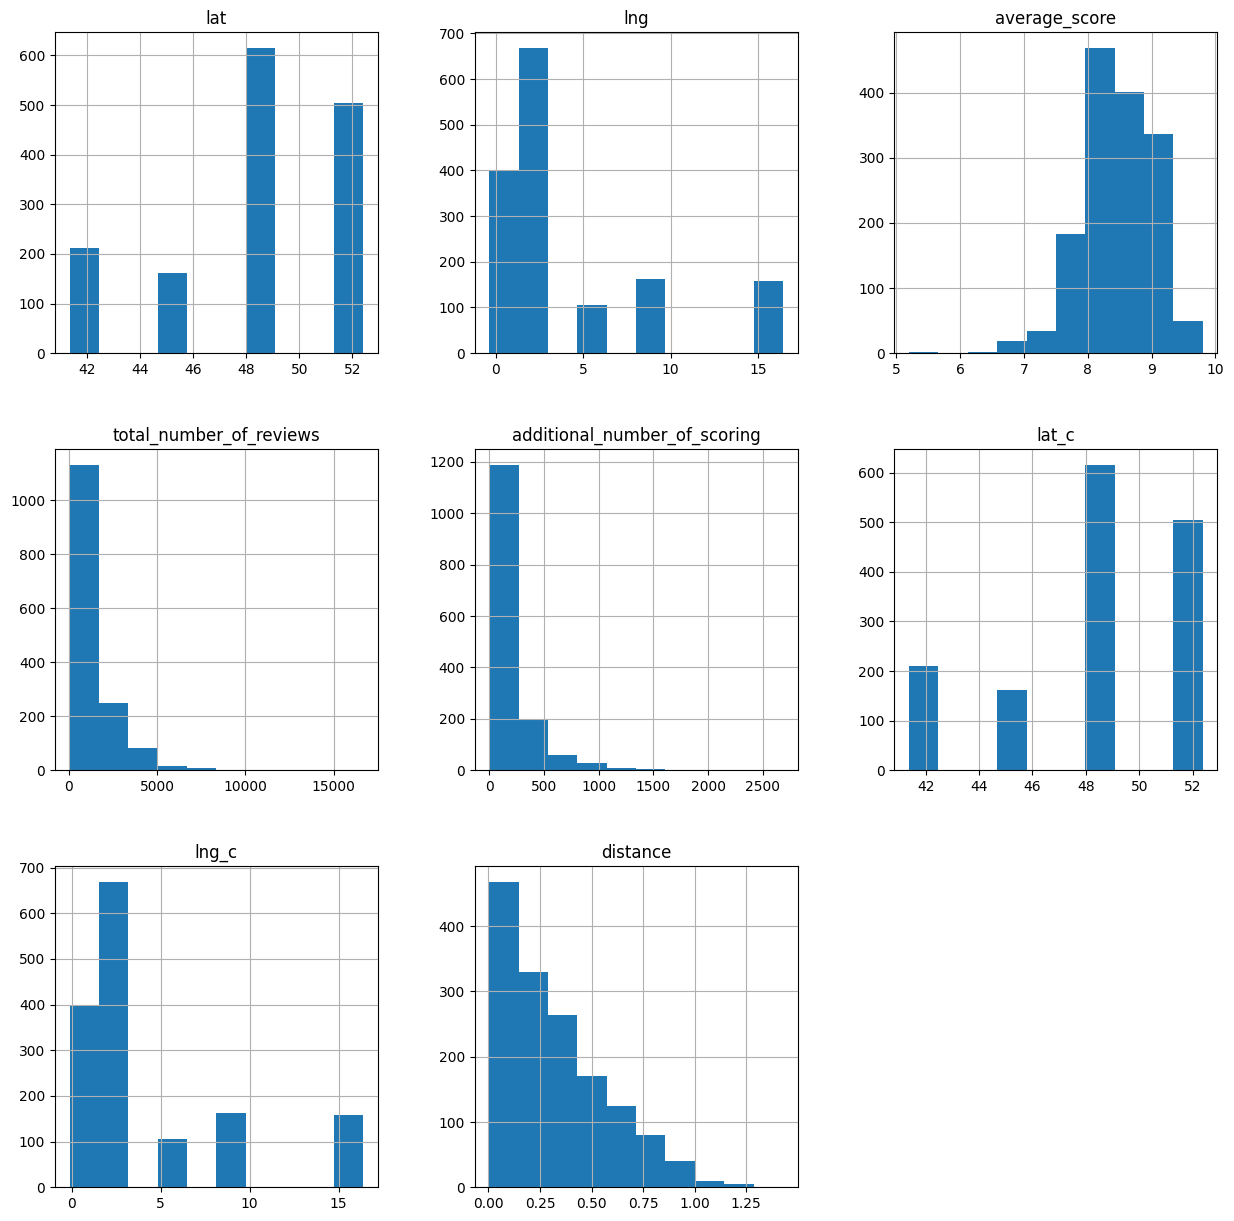

In [355]:
hotels_uniq.hist(figsize = (15,15))

Ни один признак не тянет на нормально распределенный, но есть подозрительный на логнормальное распределение &mdash; average_score.
Сделаем проверку на нормальность распределения для этого признака.

In [356]:
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'
alpha = 0.05

In [357]:
from scipy.stats import shapiro 

In [358]:
_, p = shapiro(hotels_uniq['average_score'])
print('p=%.3f' % p)

# Интерпретация 

if p > alpha:
	print(H0)
else:
	print(Ha)

p=0.000
Данные не распределены нормально (мы отвергаем H0)


p-значение ≤ 0,05, мы отклоняем нулевую гипотезу, то есть предполагаем, что распределение нашей переменной не является нормальным / гауссовым.

Повторим процедуру с проверкой на логнормальное распределение признака average_score.

In [359]:
H0 = 'Данные распределены логнормально'
Ha = 'Данные не распределены логнормально (мы отвергаем H0)'
alpha = 0.05

hotels_uniq['average_score_log'] = np.log(hotels_uniq['average_score'])
_, p = shapiro(hotels_uniq['average_score_log'])
print('p=%.3f' % p)

# Интерпретация 

if p > alpha:
	print(H0)
else:
	print(Ha)

p=0.000
Данные не распределены логнормально (мы отвергаем H0)


И снова тот же результат.

In [360]:
# удалим признак average_score_log
hotels_uniq.drop('average_score_log', axis=1, inplace=True)

Построим гистограммы расстояний от "центра" до отеля для каждого города отдельно.

Text(0, 0.5, 'Количество отелей')

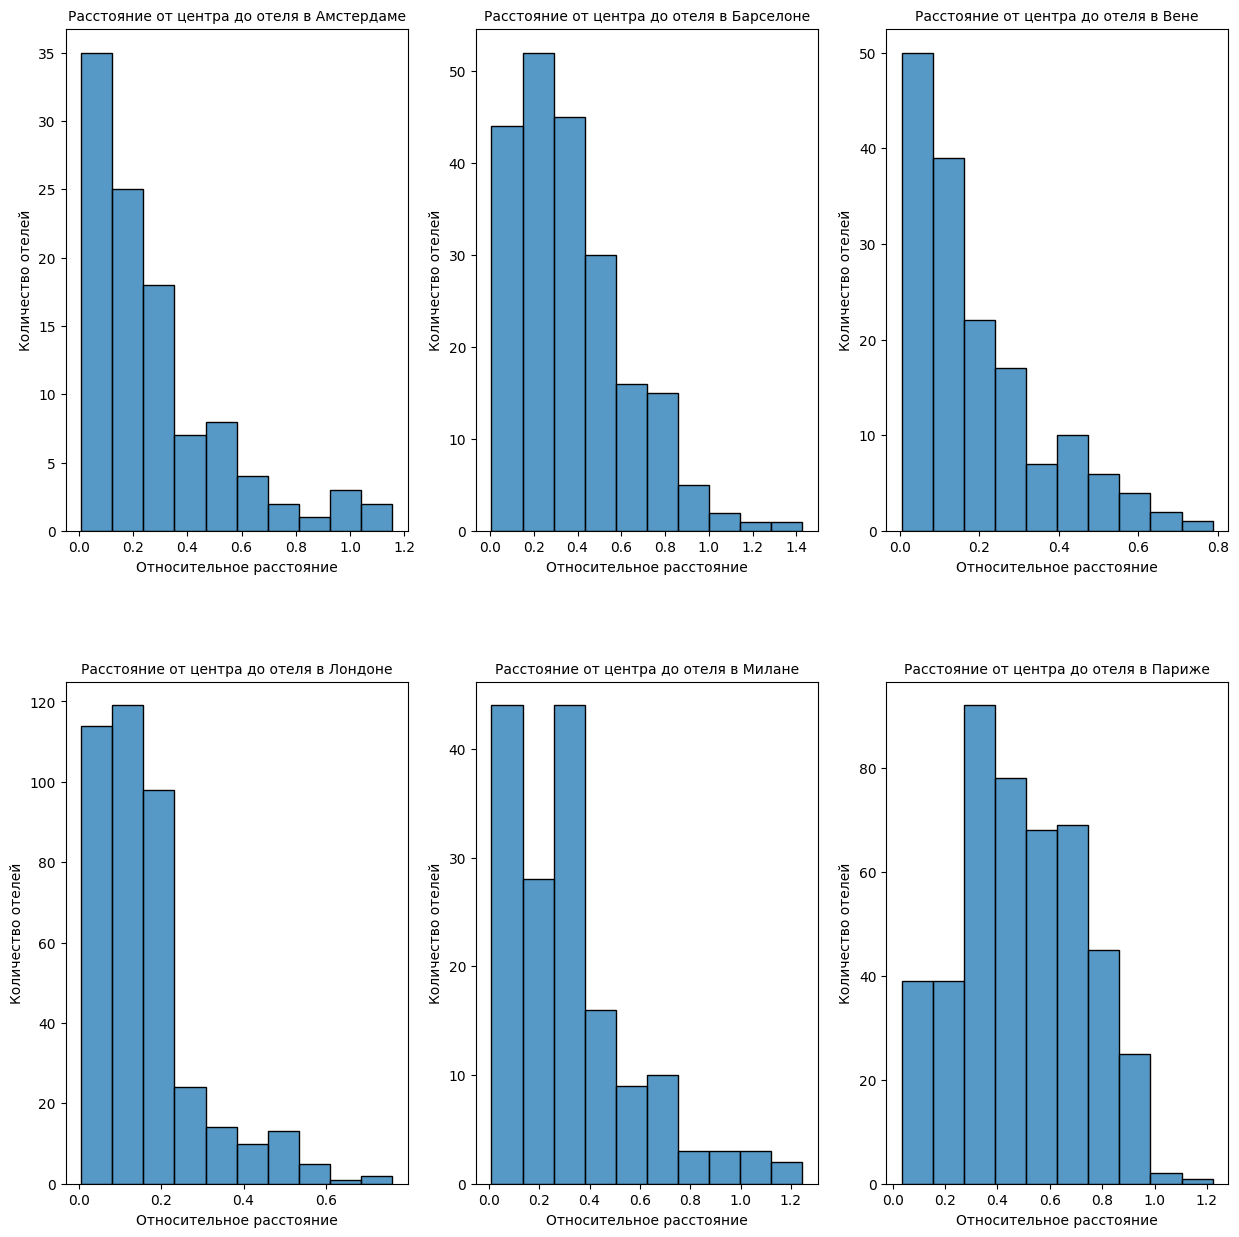

In [361]:
bins_number = 10
font = 10
x_label = 'Относительное расстояние'

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

histplot_ams = sns.histplot(data=hotels_uniq[hotels_uniq['city'] == 'Amsterdam'],
                            x='distance', bins=bins_number, ax=axes[0,0])
histplot_ams.set_title('Расстояние от центра до отеля в Амстердаме', fontsize=font)
histplot_ams.set_xlabel(x_label)
histplot_ams.set_ylabel('Количество отелей')

histplot_bar = sns.histplot(data=hotels_uniq[hotels_uniq['city'] == 'Barcelona'],
                            x='distance', bins=bins_number, ax=axes[0,1])
histplot_bar.set_title('Расстояние от центра до отеля в Барселоне', fontsize=font)
histplot_bar.set_xlabel(x_label)
histplot_bar.set_ylabel('Количество отелей')

histplot_vie = sns.histplot(data=hotels_uniq[hotels_uniq['city'] == 'Vienna'],
                            x='distance', bins=bins_number, ax=axes[0,2])
histplot_vie.set_title('Расстояние от центра до отеля в Вене', fontsize=font)
histplot_vie.set_xlabel(x_label)
histplot_vie.set_ylabel('Количество отелей')

histplot_lon = sns.histplot(data=hotels_uniq[hotels_uniq['city'] == 'London'],
                            x='distance', bins=bins_number, ax=axes[1,0])
histplot_lon.set_title('Расстояние от центра до отеля в Лондоне', fontsize=font)
histplot_lon.set_xlabel(x_label)
histplot_lon.set_ylabel('Количество отелей')

histplot_mil = sns.histplot(data=hotels_uniq[hotels_uniq['city'] == 'Milan'],
                            x='distance', bins=bins_number, ax=axes[1,1])
histplot_mil.set_title('Расстояние от центра до отеля в Милане', fontsize=font)
histplot_mil.set_xlabel(x_label)
histplot_mil.set_ylabel('Количество отелей')

histplot_par = sns.histplot(data=hotels_uniq[hotels_uniq['city'] == 'Paris'], 
                            x='distance', bins=bins_number, ax=axes[1,2])
histplot_par.set_title('Расстояние от центра до отеля в Париже', fontsize=font)
histplot_par.set_xlabel(x_label)
histplot_par.set_ylabel('Количество отелей')

Из диаграмм видно, что самое большое количество отелей сосредоточено внутри условногно городского круга. Присутствие значений, превышающих единицу (т.е. за условной городской чертой), объясняется, скорее всего, формой города (например, сильно вытянут по одному из направлений), а не наличием отелей в окрестностях.

Построим тепловую карту корреляции для признаков, относящихся к отелю.

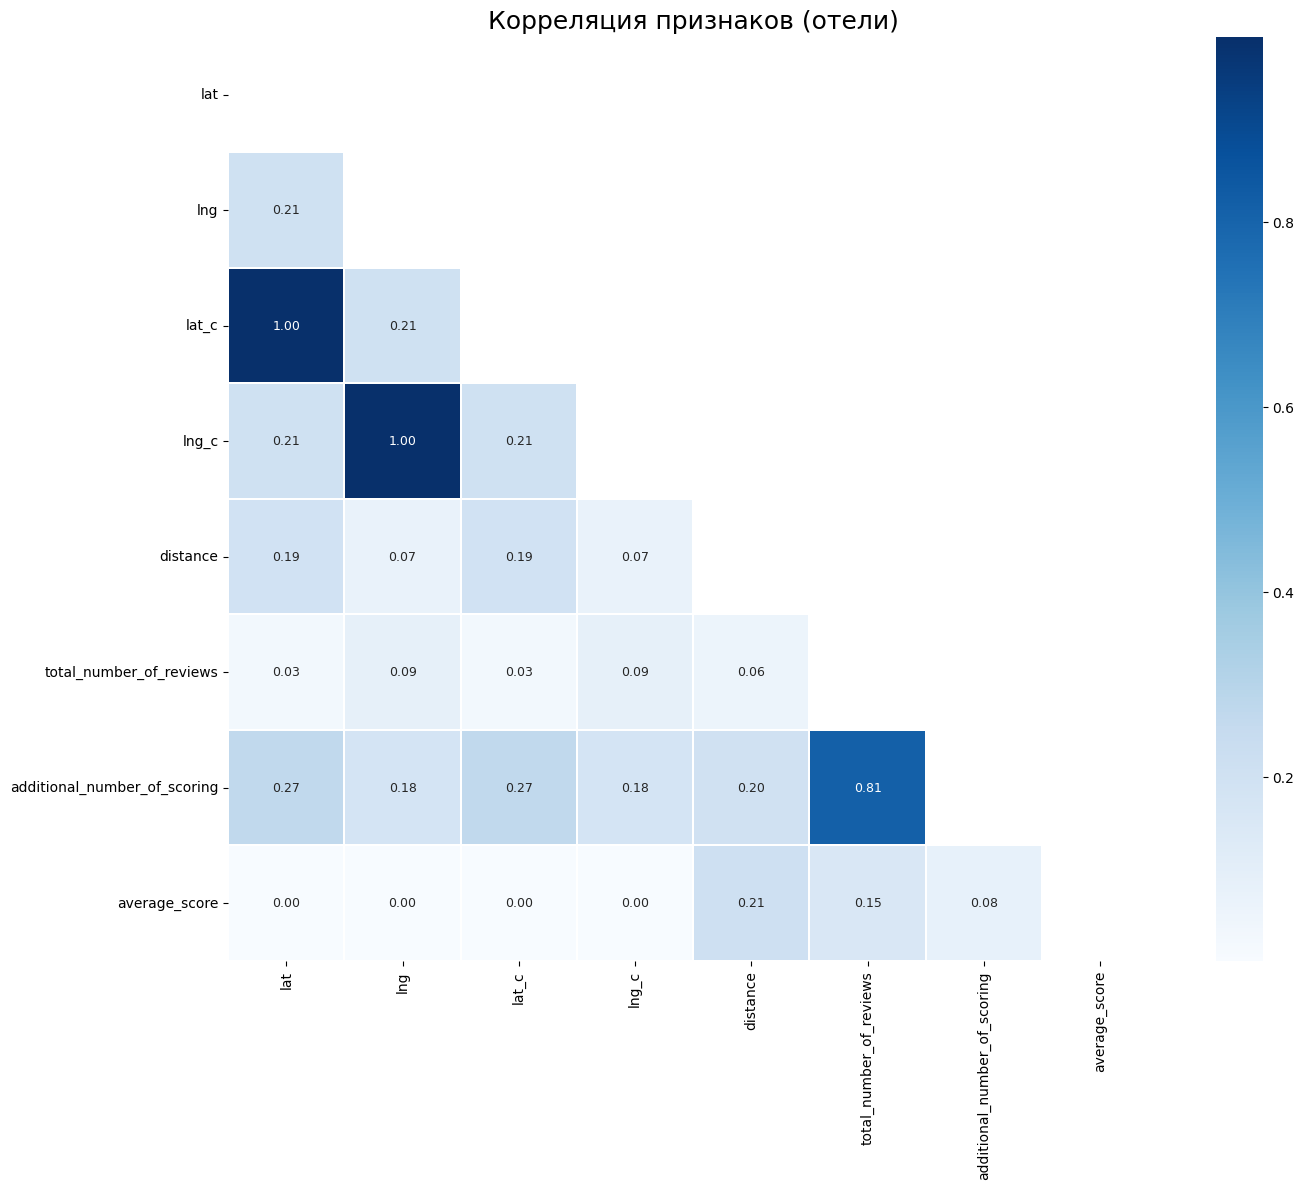

In [362]:
num_cols = ['lat','lng','lat_c','lng_c','distance','total_number_of_reviews','additional_number_of_scoring','average_score']

show_corr(hotels_uniq,num_cols, 'Корреляция признаков (отели)')


С признаками, которые относятся к отелю, мы отработали. Были определены все недостающие координаты, получены новые признаки &mdash; расстояние от "центра" города и страна. Можно сразу попробовать определить те признаки, которые не будут оказывать заметное влияние на модель, а также те, которые имеют сильную корреляцию и, соответсвенно, могут отрицательно повлиять на результат, но мы пока это делать не будем, чтобы собрать все манипуляции с признаками в одном месте.
Исключение сделаем для признаков, которые мы создали сами, и которые связаны с географией отелей. После вычисления расстояния до "центра" города, нам уже не требуются его координаты. Это видно, в том числе, и из карты корреляции. Кроме того, можно удалить столбцы 'city' и 'city_country', т.к. отели присутствуют в каждой стране только в одном городе.

In [363]:
hotels_uniq = hotels_uniq.drop(columns = ['lat_c','lng_c','city','city_country'], axis=1)
display(hotels_uniq.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1494 entries, 0 to 1493
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   hotel_name                    1494 non-null   object 
 1   hotel_address                 1494 non-null   object 
 2   lat                           1494 non-null   float64
 3   lng                           1494 non-null   float64
 4   average_score                 1494 non-null   float64
 5   total_number_of_reviews       1494 non-null   int64  
 6   additional_number_of_scoring  1494 non-null   int64  
 7   country                       1494 non-null   object 
 8   distance                      1494 non-null   float64
dtypes: float64(4), int64(2), object(3)
memory usage: 116.7+ KB


None

Можно полученные данные занести в основной датасет

Для занесения информации об отелях в основной датасет воспользуемся объединением таблиц с помощью merge.
После объединения удалим дубли столбцов, внеся перед этим пропущенные в data данные, которые были определены в hotels_uniq - lat и lng. 

In [364]:
data = data.merge(hotels_uniq, how = 'left', on='hotel_name', suffixes=('', '_y'))
data['lat'] = data['lat'].fillna(data['lat_y']) # заполнение пропущенных в первоначальном датасете данных
data['lng'] = data['lng'].fillna(data['lng_y'])
data['hotel_address'] = data['hotel_address_y'] # мы немного корректировали адреса отелей, поэтому внесем их в основной датасет
data = data.drop(columns=['lat_y', 'lng_y','average_score_y','additional_number_of_scoring_y','total_number_of_reviews_y','hotel_address_y']) # удалим дубли признаков

Рассмотрим признак review_date. Так как это признак имеет тип object, то для использования его в расчетах необходимо получить на его основе новые признаки числового типа.
Это будут признаки:
review_year - в каком году был оставлен отзыв.
review_month - в каком месяце был оставлен отзыв.
review_year_month - число, соответствующее году и месяцу, когда был оставлен отзыв.
review_day - количество дней от даты первого отзыва.

In [365]:
data['review_year'] = pd.DatetimeIndex(data['review_date']).year
data['review_month'] = pd.DatetimeIndex(data['review_date']).month
data['review_year_month'] = data['review_year']*100 + data['review_month']
data['review_weekday'] = pd.DatetimeIndex(data['review_date']).dayofweek
data['review_date'] = pd.to_datetime(data['review_date'])
data_min = data['review_date'].min()
data['review_day'] = data['review_date'].apply(lambda x: (x - data_min).days)
data = data.drop(columns=['review_year', 'review_month'])
display(data[['review_date','review_year_month','review_day']].head())
data.drop('review_date', axis = 1, inplace=True)

,review_date,review_year_month,review_day
0,2017-07-21,201707,717
1,2016-12-12,201612,496
2,2015-11-26,201511,114
3,2015-10-17,201510,74
4,2016-05-16,201605,286


Мы выделили в качестве признака страну, в которой располагается отель. Хотелось бы узнать, влияет ли расположение отеля (страна) на его оценку.

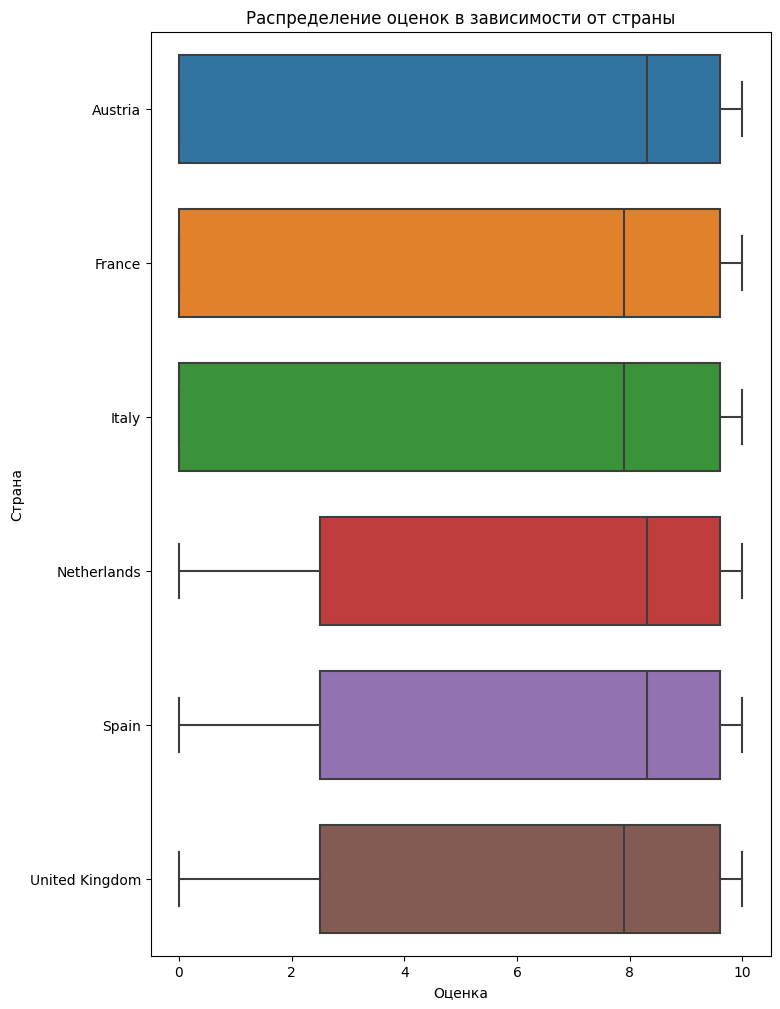

In [366]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 12))

country = sns.boxplot(
    data = data.sort_values(by='country', ascending=True),
    y = 'country',
    x = 'reviewer_score',
    orient ='h',
    width = 0.7
)

country.set(xlabel='Оценка', ylabel='Страна', title='Распределение оценок в зависимости от страны');

Из диаграммы видно, что данные по Франции и Италии, а также Нидерландам и Испании идентичны.

Рассмотрим распределение признака total_number_of_reviews &mdash; total number of hotel reviews.

[Text(0.5, 0, 'Количество оценок'),
 Text(0, 0.5, 'Страны'),
 Text(0.5, 1.0, 'Распределение количества оценок')]

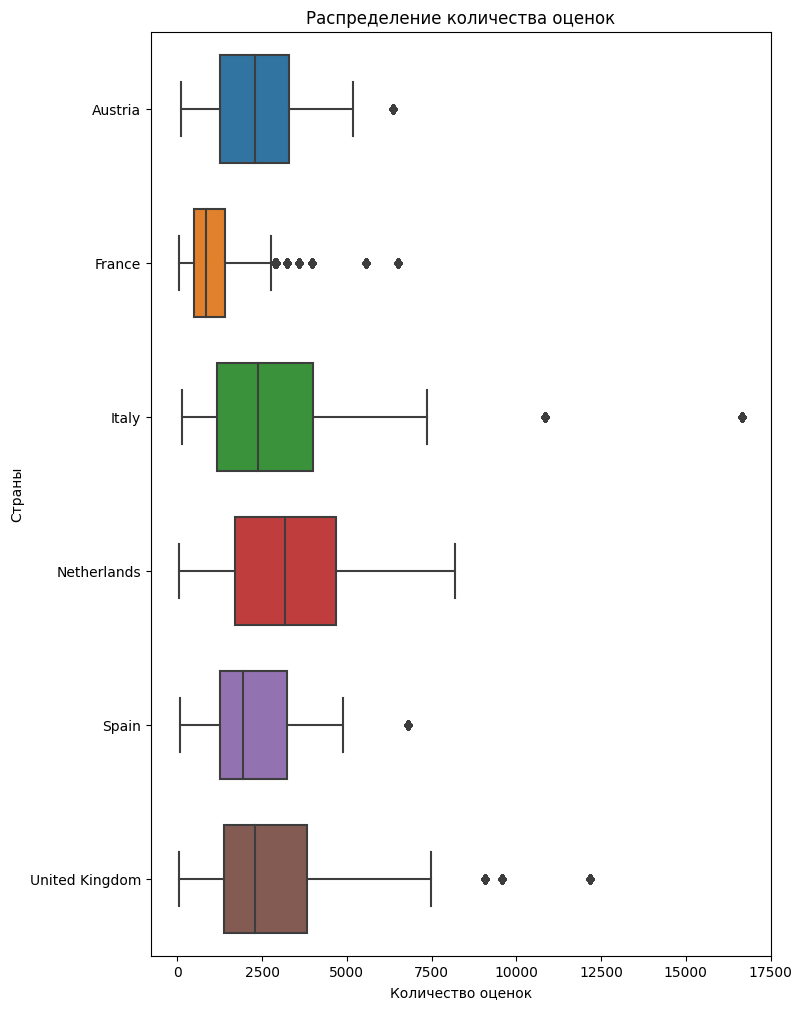

In [367]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 12))

country = sns.boxplot(
    data = data.sort_values(by='country', ascending=True),
    y = 'country',
    x = 'total_number_of_reviews',
    orient ='h',
    width = 0.7
)

country.set(xlabel='Количество оценок', ylabel='Страны', title='Распределение количества оценок')

Почти во всех странах имеются данные по количеству оценок (исключение - Нидерланды), очень похожие на выбросы. По логике самого признака там выбросов быть не должно (если отель не занимается накруткой числа оценок). Можно будет рассмотреть в дальнейшем результаты обучения модели с данными как есть, и с каким-либо вариантом сглаживания выбросов.

Выводим данные о корреляции признаков в виде тепловой карты

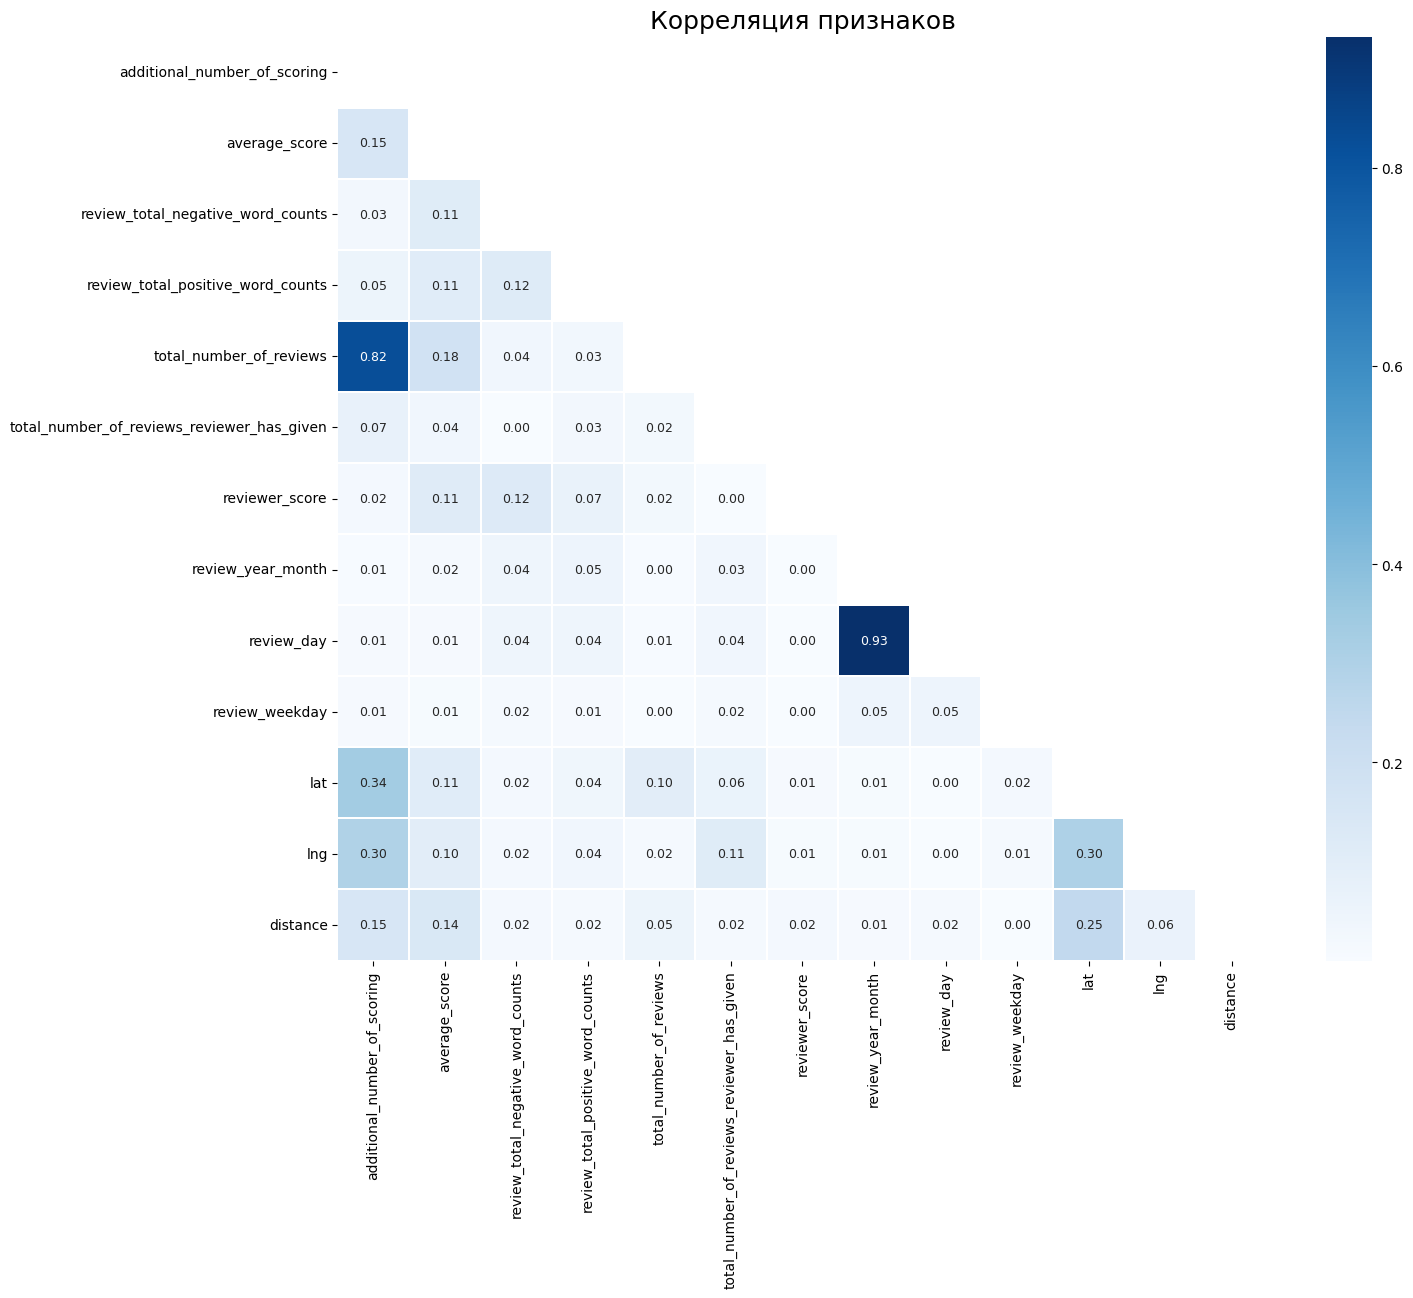

In [368]:
num_cols = ['additional_number_of_scoring','average_score',
            'review_total_negative_word_counts','review_total_positive_word_counts',
            'total_number_of_reviews','total_number_of_reviews_reviewer_has_given',
            'reviewer_score','review_year_month','review_day','review_weekday',
            'lat','lng','distance']

show_corr(data,num_cols, 'Корреляция признаков')

additional_number_of_scoring и total_number_of_reviews имеют коэффициент корреляции = 0,82; review_day и review_year_month имеют коэффициент корреляции = 0,93. Как и в предыдущем случае, мы не будем пока удалять признаки, имеющие пару с высоким коэффициентом корреляции, оставив это на последний этап.

<h2>Данные, относящиеся к рецензенту</h2>

В первую очередь рассмотрим признак национальности (вернее было бы сказать, гражданства) рецензента

In [369]:
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip())

display(data['reviewer_nationality'].value_counts(normalize=True).head(10))

United Kingdom              0.475650
United States of America    0.068661
Australia                   0.042029
Ireland                     0.028753
United Arab Emirates        0.019847
Saudi Arabia                0.017354
Netherlands                 0.016999
Switzerland                 0.016825
Germany                     0.015397
Canada                      0.015302
Name: reviewer_nationality, dtype: float64

In [370]:
display(data['reviewer_nationality'].nunique())

227

Среди рецензентов встречаются жители 227 стран. При этом на долю туристов из Великобритации приходится почти половина рецензентов. Следующие на втором месте рецензенты из США уступают Великобритании примерно в семь раз. 

Можно учесть еще один момент: рецензентом может оказаться житель страны, об отеле которой он оставил отзыв, а может быть и иностранный гражданин. Попробуем посмотреть, как создание признака совпадения стран рецензента и отеля скажется на итоговом результате.

In [371]:
data['country_reviewer'] = data.apply(lambda x: 1 if x['reviewer_nationality'] == x['country'] else 0, axis=1)

display(data['country_reviewer'].value_counts(normalize=True))

0    0.653913
1    0.346087
Name: country_reviewer, dtype: float64

Переведем признак "национальность рецензента" в категориальный. При этом ограничимся первыми 63 странами по количеству рецензентов, все остальные пометим именами континентов (регионов), на которых расположены страны. В процессе работы с признаком национальность выяснилось, что для него имеются пустые данные, которые не были обнаружены изначально. Для таких рецензентов у нас есть только один вариант &mdash; выбрать в качестве названия страны/континента/региона наименование "Other".

In [372]:
# определение по названию страны континента
def country_to_continent(country_name):
# не для всех стран удается определить континент с помощью библиотеки pycountry_convert
# для этих стран создадим словарь, который содержит в качестве ключа название страны, а в качестве значения - континент (регион)
# для некоторых рецензентов данные о стране отсутствуют, все такие случаи будут отнесены к категории "Other"
    country_dict = {'Vatican City':'Europe',
                    'Central Africa Republic':'Africa',
                    'Kosovo':'Europe',
                    'Svalbard Jan Mayen':'Europe',
                    'Palestinian Territory':'Asia',
                    'Abkhazia Georgia':'Asia',
                    'Cura ao':'Latin America and the Caribbean',
                    'U S Virgin Islands':'Latin America and the Caribbean',
                    'Cocos K I':'Oceania',
                    'Crimea':'Russia',
                    'East Timor':'Asia',
                    'St Pierre and Miquelon':'North America',
                    'Antarctica':'Antarctica',
                    'Falkland Islands Malvinas':'Latin America and the Caribbean',
                    'Reunion':'Africa',
                    'Saint Vincent Grenadines':'Latin America and the Caribbean',
                    'Antigua Barbuda':'Latin America and the Caribbean',
                    'Turks Caicos Islands':'Latin America and the Caribbean',
                    'Bonaire St Eustatius and Saba':'Latin America and the Caribbean',
                    'Saint Barts':'Latin America and the Caribbean',
                    'United States Minor Outlying Islands':'Oceania',
                    'St Maarten':'Latin America and the Caribbean',
                    }
    
 # т.к. функция convert_continent_code_to_continent_name не всегда может сопоставить страну и континент, выдавая в этом случае ошибку, используем блок try-except
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    except:
        if country_dict.get(country_name,None) is not None:
            country_continent_name = country_dict[country_name]
        else:
            country_continent_name = 'Other'
    
    return country_continent_name

In [373]:
# функция уменьшения числа категорий стран
def reduce_categories_country(df, col, n):
    popular_values = df[col].value_counts().nlargest(n).index
    df[col] = df[col].apply(lambda x: x if x in popular_values else country_to_continent(x))
    return df

In [374]:
# уменьшение числа категорий
data = reduce_categories_country(data, 'reviewer_nationality', 63)

In [375]:
display(data['reviewer_nationality'].unique())

array(['United Kingdom', 'Belgium', 'Sweden', 'United States of America',
       'South America', 'Netherlands', 'Ireland', 'Canada', 'Norway',
       'Bulgaria', 'Italy', 'Australia', 'Africa', 'Kuwait',
       'Saudi Arabia', 'Czech Republic', 'France', 'Germany',
       'South Africa', 'United Arab Emirates', 'Greece', 'Spain',
       'Switzerland', 'Europe', 'Poland', 'Bahrain', 'Qatar', 'India',
       'Singapore', 'Malaysia', 'Thailand', 'Brazil', 'Russia', 'Turkey',
       'Israel', 'Other', 'Lebanon', 'Romania', 'Cyprus', 'Portugal',
       'Slovakia', 'Jersey', 'Austria', 'North America', 'Oman',
       'Hungary', 'Iceland', 'Estonia', 'Hong Kong', 'China', 'Malta',
       'Pakistan', 'Slovenia', 'South Korea', 'Ukraine', 'Japan', 'Asia',
       'Serbia', 'Denmark', 'Egypt', 'Finland', 'Taiwan', 'Philippines',
       'New Zealand', 'Luxembourg', 'Indonesia', 'Croatia', 'Iran',
       'Nigeria', 'Latin America and the Caribbean', 'Oceania',
       'Antarctica'], dtype=object)

In [376]:
display(data['reviewer_nationality'].value_counts())

United Kingdom                     245165
United States of America            35390
Australia                           21663
Ireland                             14820
United Arab Emirates                10230
                                    ...  
Estonia                               757
Other                                 523
Oceania                               152
Latin America and the Caribbean       111
Antarctica                              3
Name: reviewer_nationality, Length: 72, dtype: int64

In [377]:
display(data['reviewer_nationality'].value_counts(normalize=True).head(16))

United Kingdom              0.475650
United States of America    0.068661
Australia                   0.042029
Ireland                     0.028753
United Arab Emirates        0.019847
Saudi Arabia                0.017354
Netherlands                 0.016999
Switzerland                 0.016825
Germany                     0.015397
Canada                      0.015302
France                      0.014118
Israel                      0.012813
Italy                       0.011860
Belgium                     0.011693
Turkey                      0.010556
Kuwait                      0.009542
Name: reviewer_nationality, dtype: float64

Для полученичения наглядной картины зависимости оценок рецензентов от их национальной принадлежности построим гистограмму.

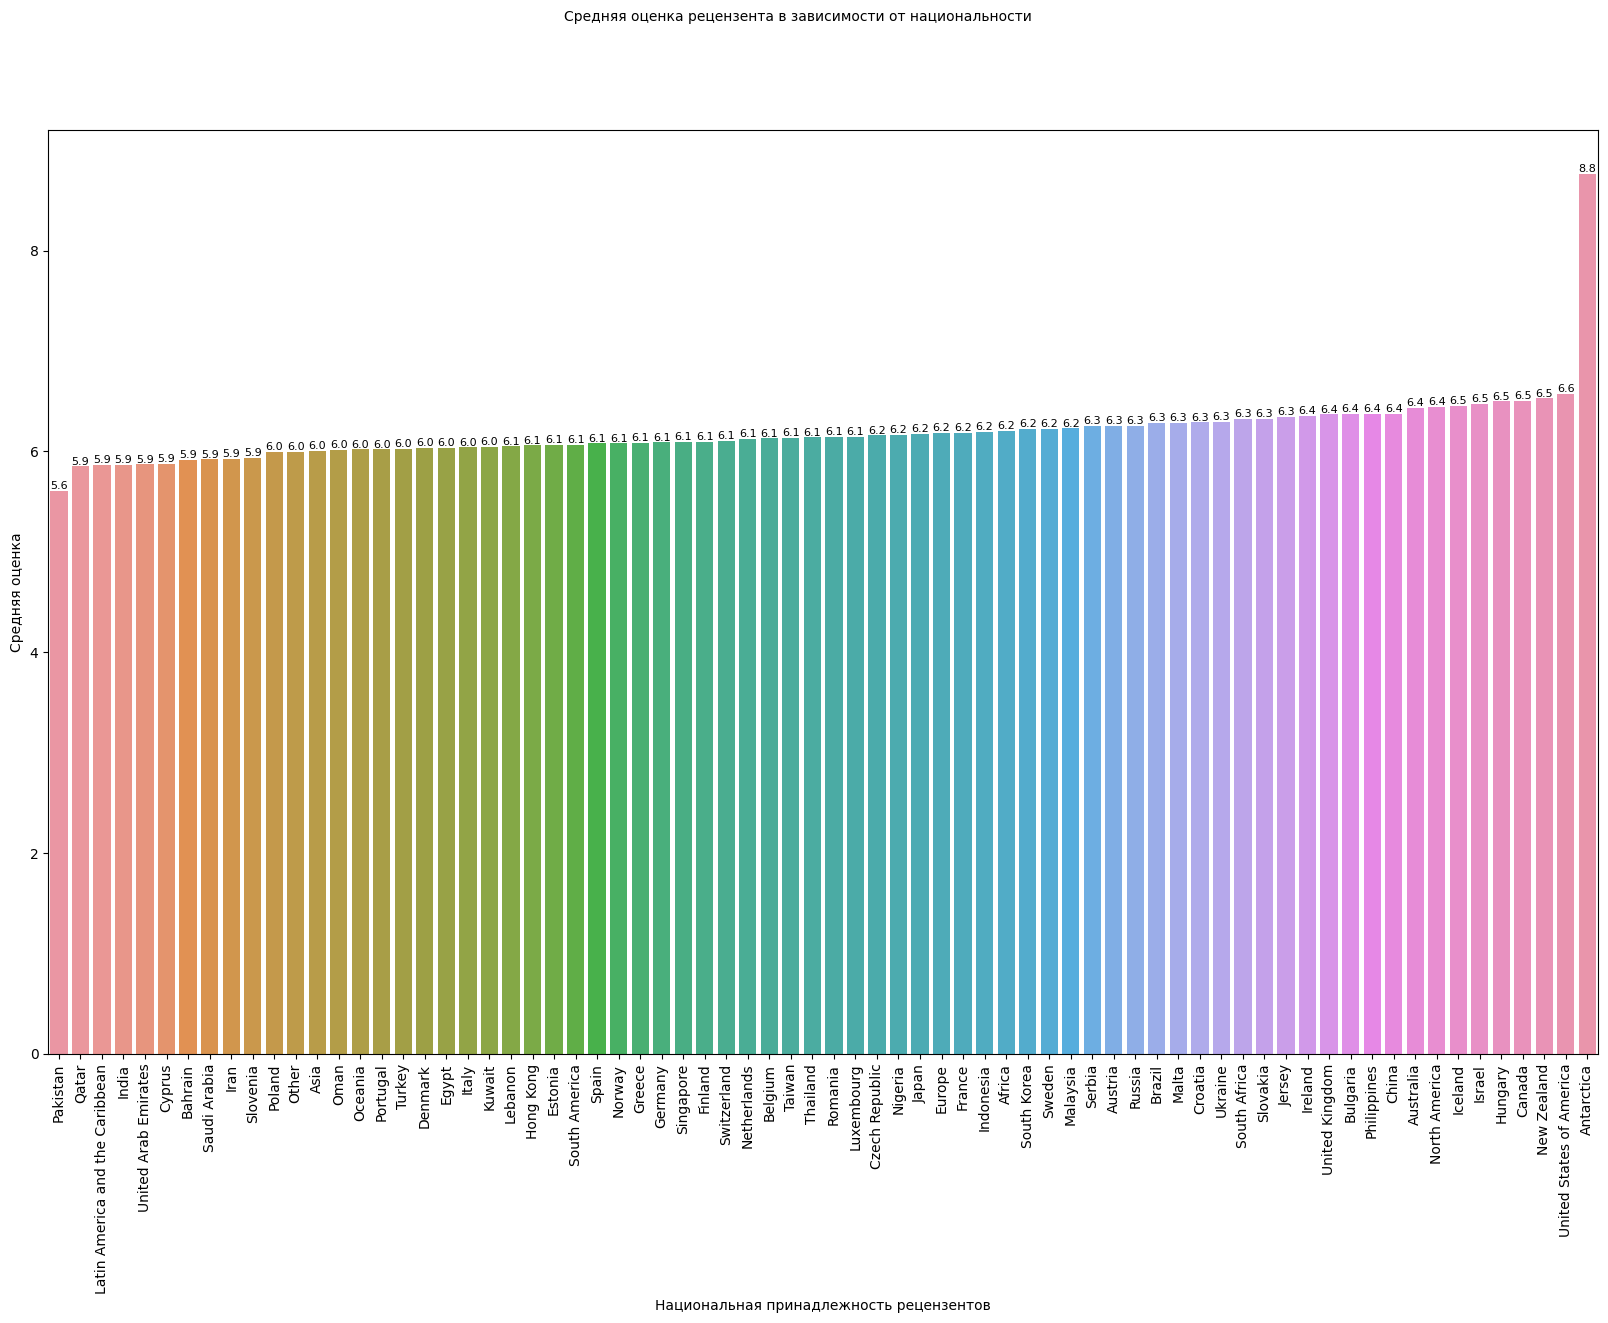

In [378]:
grouped = data.groupby(by='reviewer_nationality')['reviewer_score'].agg(['mean']).sort_values('mean')

fig, ax = plt.subplots(figsize=(20,12))

plt.suptitle('Средняя оценка рецензента в зависимости от национальности', size=10)
bar_types = sns.barplot(x=grouped.index, y=grouped['mean'])

for p in bar_types.patches:
    bar_types.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+.4, p.get_height()),
    ha='center', va='bottom', fontsize=8)

    plt.xlabel('Национальная принадлежность рецензентов', size=10)
    plt.ylabel('Средняя оценка', size=10)
    plt.xticks(rotation=90)

Из гистограммы видно, что из общего довольно однородного по средней оценке ряда стран, сильно выбивается загадочная Antarctica. Не очень понятно, кто отнес себя к жителям данного континента, можно только предположить, что это полярники, длительное время находившиеся на какой-нибудь научной станции этого южного континента. После работы в столь суровых условиях любой отель покажется царским дворцом. Отбрасывать их мнение мы не будем, но оценим количество таких рецензентов и отнесем их к категории Other, что должно нивелировать их восторженное мнение.

In [379]:
display(data[data['reviewer_nationality'] == 'Antarctica'][['hotel_name','average_score','review_year_month']])

,hotel_name,average_score,review_year_month
145032,Park Plaza Sherlock Holmes London,8.2,201601
145046,Pakat Suites Hotel,8.6,201609
209197,Hotel Prinz Eugen,8.3,201609


Таких рецензентов всего трое. 

In [380]:
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: 'Other' if x == 'Antarctica' else x)

Еще одна подозрительная страна - Jersey. Это остров в проливе Ла-Манш. Если верить информации из интернета &mdash; рай для британских пенсионеров. Узнаем количество рецензентов из данной местности.

In [381]:
display(data[data['reviewer_nationality'] == 'Jersey'][['hotel_name','average_score','review_year_month']])

,hotel_name,average_score,review_year_month
154,Blakemore Hyde Park,8.5,201702
1498,Oceania Paris Porte De Versailles,8.2,201707
1704,Sloane Square Hotel,8.2,201610
2222,DoubleTree by Hilton Hotel London Tower of London,8.7,201606
3598,Best Western Plus Seraphine Hammersmith Hotel,7.8,201605
...,...,...,...
513554,Radisson Blu Edwardian Berkshire,8.1,201612
513855,The Grosvenor,8.4,201601
513863,Fifty Four Boutique Hotel,8.2,201605
513907,Britannia International Hotel Canary Wharf,7.1,201610


Таких рецензентов довольно много (862). Лучше оставить эту категорию рецензентов в том виде, в котором она существует сейчас.

Т.к. у нас в итоге получилось 72 значения, то применим бинарное кодирование признака "национальность".

In [382]:
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

data.head(2)

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,review_weekday,review_day,country_reviewer,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,4,717,0,0,0,0,0,0,0,1
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,...,0,496,0,0,0,0,0,0,1,0


Можно вспомнить диаграмму распределения оценок отеля в зависимости от страны и объединить в оду условную страну Францию и Италию, Нидерланды и Испанию.

In [383]:
def union_country(x):
    if x in ('Netherlands', 'Spain'):
        return 'Netherlands_Spain'
    elif x in ('France','Italy'):
        return 'France_Italy'
    else:
        return x
    
data['country_union'] = data['country'].apply(union_country)

In [384]:
# кодируем страны через OneHotEncoder
encoder = ce.OneHotEncoder(cols=['country_union'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['country_union'])
data = pd.concat([data, type_bin], axis=1)

data.head(2)


,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,country_union,country_union_France_Italy,country_union_Netherlands_Spain,country_union_United Kingdom,country_union_Austria
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,0,0,0,0,1,France_Italy,1,0,0,0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,...,0,0,0,1,0,Netherlands_Spain,0,1,0,0


Переходим к следующему признаку - tags. Изнего можно попробовать получить достаточно большое количество новых признаков.

Создадим признак tags_list, который будет содержать теги в отзыве в виде списка

In [385]:
import re

pattern = "\[\' | \'\]| \', \'"

data['tags_list'] = data['tags'].apply(lambda s: re.split(pattern, s)[1:-1])
display(data['tags_list'])


0         [Leisure trip,  Couple,  Double Room,  Stayed ...
1         [Leisure trip,  Group,  Triple Room,  Stayed 1...
2         [Business trip,  Solo traveler,  Twin Room,  S...
3         [Leisure trip,  Couple,  Ambassador Junior Sui...
4         [Business trip,  Solo traveler,  Classic Doubl...
                                ...                        
515426    [Leisure trip,  Group,  Club Double or Twin Ro...
515427    [Leisure trip,  Couple,  Standard Double Room,...
515428    [Business trip,  Solo traveler,  Single Room, ...
515429    [Leisure trip,  Solo traveler,  Deluxe Double ...
515430    [Leisure trip,  Couple,  Bunk Bed Room,  Staye...
Name: tags_list, Length: 515431, dtype: object

Получаем новый признак tagn - количество тегов в отзыве tags_list

In [386]:
data['tagn'] = data['tags_list'].apply(len)

data['tagn'].value_counts(normalize=True)

5    0.577499
4    0.410187
3    0.010673
6    0.001465
2    0.000165
1    0.000012
Name: tagn, dtype: float64

In [387]:
display(data['tagn'].max())

6

Можно заметить, что количество тегов в отзыве любого рецензента не превышает шести.

Из признака tags получим количество ночей, которвые провел рецензент в отеле.

In [388]:
def hotels_days(tag_day):
    match = re.search('Stayed \d{1,3} night',tag_day)
    if match:
        return int(match[0].split(' ')[1])
    else:
        return 0

data['night'] = data['tags'].apply(hotels_days)
display(data['night'].value_counts())

1     193568
2     133850
3      95761
4      47777
5      20826
6       9765
7       7391
8       2499
9       1293
10       888
11       417
12       316
14       247
13       246
0        192
15       117
16        57
17        42
18        33
19        29
21        23
20        19
27        11
30        11
23        10
22        10
25         7
26         7
28         7
24         6
29         5
31         1
Name: night, dtype: int64

Количество ночей, которые провел рецензент в отеле, варьируется от 0 до 31. Наиболее популярный диапазон - от 1 до 7 дней. Сузим диапазон от 1 до 7, все остальное будем считать равным 8 (значение 0 заменим единицей)

In [389]:
data['night'] = data['night'].apply(lambda x: 8 if  x > 7 else max(1, x) )

Самые простые и очевидные данные из тегов мы извлекли. Теперь можно попробовать посмотреть на теги более внимательно. Для этого создадим словарь, где ключами будут выступать теги, а значениями - количество, встречающееся в датасете. В словарь мы не будем включать теги, связанные с количеством дней пребывания в отеле, т.к. этот признак мы уже отработали.

In [390]:
tag_dic = {}
i=0
for index,irow in data[['tags_list']].iterrows():
    for l in irow[0]:
        if l.find('Stayed') == -1: # не будем включать в словарь тег "количество ночей", т.к. его мы уже обработали
            l = l.strip(' ')
            i = tag_dic.get(l,0)
            i = i + 1
            tag_dic.update({l:i})

tag_dic = dict(sorted(tag_dic.items(), key=lambda x: x[1], reverse=True))
display(tag_dic)

{'Leisure trip': 417538,
 'Submitted from a mobile device': 307470,
 'Couple': 252128,
 'Solo traveler': 108476,
 'Business trip': 82884,
 'Group': 65361,
 'Family with young children': 60989,
 'Double Room': 35207,
 'Standard Double Room': 32247,
 'Superior Double Room': 31361,
 'Family with older children': 26334,
 'Deluxe Double Room': 24812,
 'Double or Twin Room': 22393,
 'Standard Double or Twin Room': 17479,
 'Classic Double Room': 16877,
 'Superior Double or Twin Room': 13570,
 '2 rooms': 12384,
 'Standard Twin Room': 9745,
 'Single Room': 9668,
 'Twin Room': 8320,
 'Executive Double Room': 6425,
 'Classic Double or Twin Room': 6100,
 'Superior Twin Room': 6054,
 'Deluxe Double or Twin Room': 5996,
 'Club Double Room': 5908,
 'Queen Room': 5472,
 'Deluxe King Room': 5357,
 'Superior Queen Room': 4897,
 'Standard Single Room': 4615,
 'Junior Suite': 4555,
 'Triple Room': 4493,
 'Classic Room': 4416,
 'Superior Room': 4402,
 'Superior King Room': 4248,
 'Standard Room': 4191,
 'D

In [391]:
display(len(tag_dic.keys()))

2397

In [392]:
display(tag_dic['Travelers with friends'])

2143

Учитывать все теги достаточно затратно и, скорее всего, не нужно. Рассмотрим несколько тегов, встречающихся чаще всего, и создадим из них признаки.

Leisure trip - самый популярный тег. Т.к. он относится к поездке на отдых, то логично добавить и признак командировки - Business trip. Посмотрим, все ли поездки можно отнести к этим двум типам, или у нас есть отзывы, в которых тип поездки не указан.


In [393]:
display(data.shape[0] - (tag_dic['Leisure trip'] + tag_dic['Business trip']))

15009

Существует 15 009 отзывов, где отсутствую теги Leisure trip или Business trip. Посмотрим, есть ли еще какие-то варианты, связанные с типом поездки.

In [394]:
for key in tag_dic.keys():
    if key.find('trip') > -1:
        if not re.search('Leisure|Business',key):
            display(key)
        

Увы, часть рецензентов не указала тип поездки. Попробуем в таком случае сделать три признака: Leisure trip, Business trip и Other trip.

In [395]:
data['Leisure_trip'] = data['tags'].apply(lambda x: 0 if x.find('Leisure trip') == -1 else 1)
data['Business_trip'] = data['tags'].apply(lambda x: 0 if x.find('Business trip') == -1 else 1)
data['Other_trip'] = data['tags'].apply(lambda x: 1 if x.find('Business trip') == -1 and x.find('Leisure trip') == -1 else 0)

In [396]:
display(data[['Leisure_trip','Business_trip','Other_trip']].value_counts())

Leisure_trip  Business_trip  Other_trip
1             0              0             417538
0             1              0              82884
              0              1              15009
dtype: int64

Логично добавить также признаки, связанные с количеством и составом компании. Для этого создадим признаки Solo_traveler, Couple, Group, Family_with_older_children и Family_with_young_children.
Еще часто встечается тег Submitted from a mobile device - учтем пока и его.
Можно еще заметить, что встречаются теги, характеризующие сам номер, в котором останавливались рецензенты, но характеристик номеров достаточно много, не все отели имеют королевские аппартаменты, поэтому пока не будем заострять на них внимание.

In [397]:
data['Couple'] = data['tags'].apply(lambda x: 0 if x.find('Couple') == -1 else 1)
data['Group'] = data['tags'].apply(lambda x: 0 if x.find('Group') == -1 and x.find('Travelers with friends') == -1 else 1)
data['Family_with_older_children'] = data['tags'].apply(lambda x: 0 if x.find('Family with older children') == -1 else 1)
data['Family_with_young_children'] = data['tags'].apply(lambda x: 0 if x.find('Family with young children') == -1 else 1)
data['Solo_traveler'] = data['tags'].apply(lambda x: 1 if (x.find('Couple') == -1 and x.find('Group') == -1 and x.find('Travelers with friends') == -1 and x.find('Family with older children') == -1 and x.find('Family with young children') == -1)  else 0)

data['Submitted_from_a_mobile_device'] = data['tags'].apply(lambda x: 0 if x.find('Submitted from a mobile device') == -1 else 1)

In [398]:
display(data[['Couple','Group','Family_with_older_children','Family_with_young_children','Solo_traveler']].value_counts())

Couple  Group  Family_with_older_children  Family_with_young_children  Solo_traveler
1       0      0                           0                           0                252128
0       0      0                           0                           1                108476
        1      0                           0                           0                 67504
        0      0                           1                           0                 60989
               1                           0                           0                 26334
dtype: int64

Попробуем выбрать из тегов данные о номере, в котором останавливался рецензент.

In [399]:
list_of_key = ['room','apartment','suite','studio','deluxe','double','floor','standard','superior','maisonette','king','queen','penthouse','duplex','townhouse','atrium','cosy','cozy','classique','classic','luxury','loft','twin','offer','cottage']
list_room = []
i = 0
for key,value in tag_dic.items():
    if any(key.lower().find(s) > -1 for s in list_of_key):
        list_room.append(key)
        i += value

list_room.sort(key=len)
list_room.reverse()
display(list_room)
display(len(list_room))
display(i)

['Double or Twin Room with Extra Bed 3 Adults with Free Airport Shuttle Service from 5 00am to 00 30am',
 'Executive Room with views of Paris Queen size bed and Double Sofa Bed 2 Adults 2 Children',
 'Superior Double or Twin Room with Free Airport Shuttle Service from 5 00am to 00 30am',
 'Junior Suite 2 Adults with Free Airport Shuttle Service from 5 00am to 00 30am',
 'Double Room 1 Adult with Free Airport Shuttle Service from 5 00am to 00 30am',
 'Executive Room with queen size bed and double sofa bed 2 adults 2 children',
 'Executive Suite with Free Airport Shuttle Service from 5 00am to 00 30am',
 'Executive Room with queen size bed and single sofa bed 2 Adults 1 child',
 'Two Bedroom Family Joining Suite with Mobile Phone 2 adults 3 children',
 'Executive Double Room Eiffel Tower View with 1 Queensize and Sofa Bed',
 'Special Offer Comfort Double Room with Breakfast and Parking Included',
 'Superior Room with Queensize Bed and Single Sofa Bed 2 Adults 1 Child',
 'Special Offer Ex

2379

515218

Мы смогли выбрать сведения о номере почти для всех рецензентов. Остальные не оставили в тегах никаких данных о номере.

Выделим найденные теги номеров, в которых останавливался рецензент в отдельный признак.

In [400]:
def tag_room(x):
    for s in list_room:
        if x.lower().find(s.lower()) > -1:
            return s
    return 'Other'

data['room'] = data['tags'].apply(tag_room)

In [401]:
display(data['room'].value_counts())

Double Room                           35207
Standard Double Room                  32247
Superior Double Room                  31361
Deluxe Double Room                    24812
Double or Twin Room                   22393
                                      ...  
Townhouse Apartment                       1
Rooftop Suite                             1
Deluxe Suite 4 Adults                     1
Duplex King Suite 3 Adults                1
Quadruple Room 2 Adults 2 Children        1
Name: room, Length: 2373, dtype: int64

In [402]:
display(data['room'].nunique())

2373

Количество вариантов номеров получилось достаточно большим. Уменьшим количество категорий до 63 и воспользуемся бинарным кодированием.

In [403]:
data = reduce_categories(data, 'room', 63)

In [404]:
bin_encoder = ce.BinaryEncoder(cols=['room']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['room'])
data = pd.concat([data, type_bin], axis=1)

data.head(2)

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,Solo_traveler,Submitted_from_a_mobile_device,room,room_0,room_1,room_2,room_3,room_4,room_5,room_6
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,0,0,Double Room,0,0,0,0,0,0,1
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,...,0,0,Triple Room,0,0,0,0,0,1,0


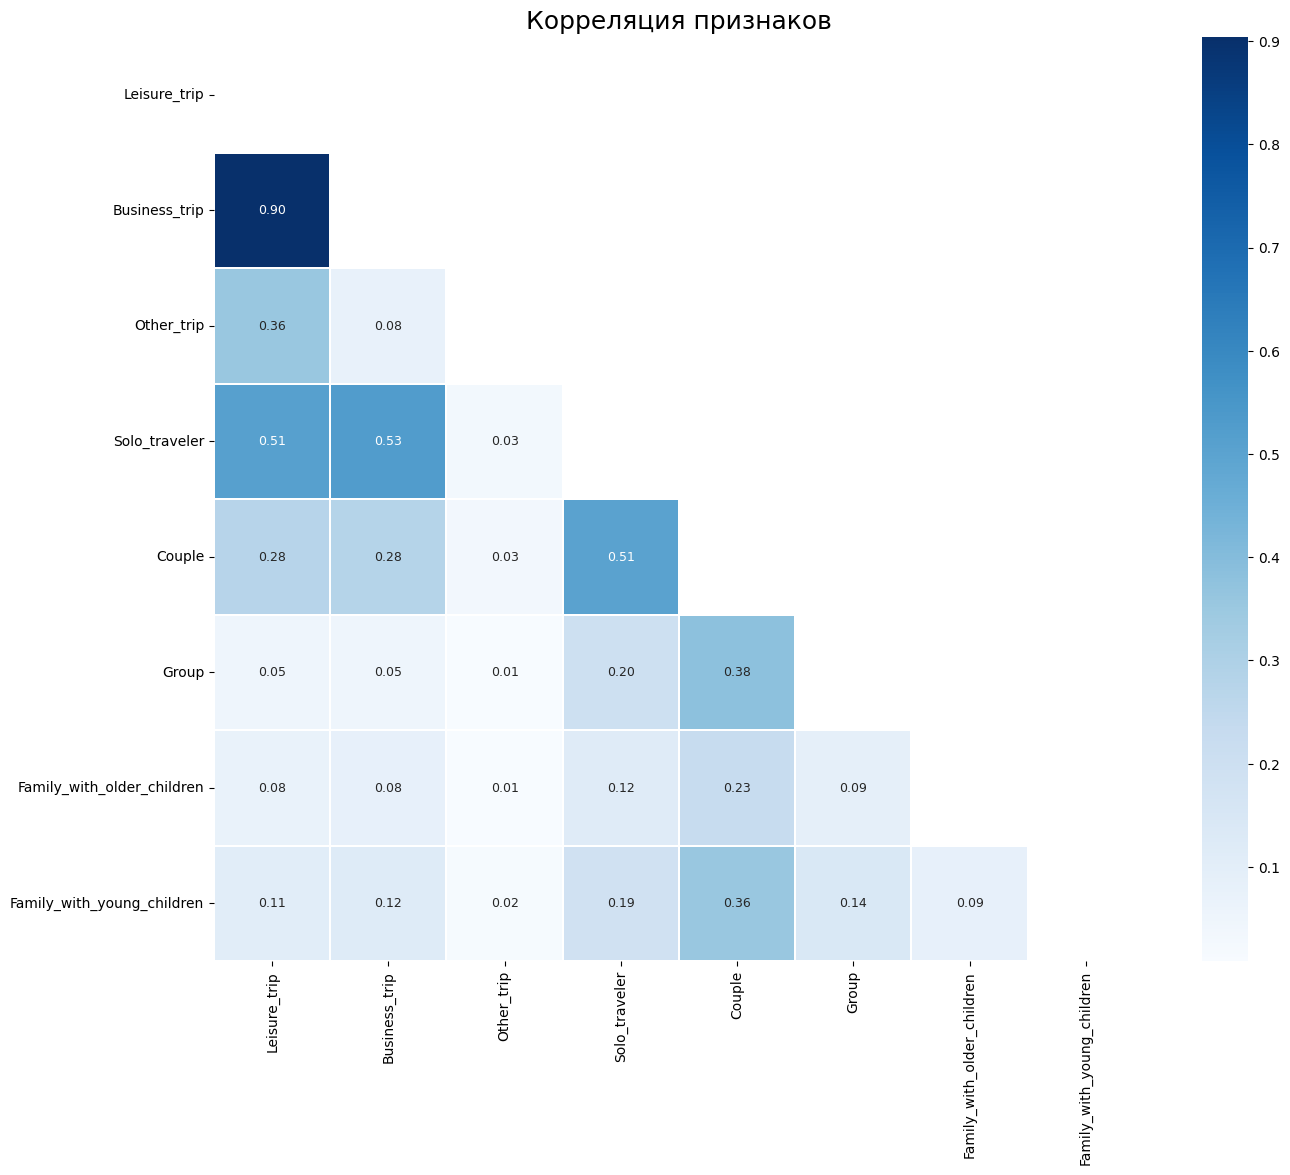

In [405]:
num_cols = ['Leisure_trip','Business_trip','Other_trip','Solo_traveler','Couple','Group','Family_with_older_children','Family_with_young_children']

show_corr(data,num_cols, 'Корреляция признаков')

Из тепловой карты следует очевидный вывод, что наличие двух признаков - Leisure trip и Business trip - является избыточным. Позже мы удалим один из них.

<h2>Данные, относящиеся к отзывам</h2>

Введем еще один признак - разницу в количестве слов для положительного и отрицательного отзывов.

In [406]:
data['review_diff'] = data['review_total_positive_word_counts'] - data['review_total_negative_word_counts']

Попробуем разобрать на признаки отрицательные и положительные отзывы.

In [407]:
data['negative_review'] = data['negative_review'].apply(lambda s: s.lower())
data['positive_review'] = data['positive_review'].apply(lambda s: s.lower())

data['neg_review_tokenized'] = data['negative_review'].apply(lambda s: s.split())
data['pos_review_tokenized'] = data['positive_review'].apply(lambda s: s.split())


In [408]:
def nltk_sentiment_analysis(df, col, prefix, sia):
#     sia = SentimentIntensityAnalyzer()
    df['polarity_scores'] = df[col].apply(sia.polarity_scores)
    
    df['nltk_'+prefix+'neg']      = df['polarity_scores'].apply(lambda x: x['neg'])
    df['nltk_'+prefix+'neu']      = df['polarity_scores'].apply(lambda x: x['neu'])
    df['nltk_'+prefix+'pos']      = df['polarity_scores'].apply(lambda x: x['pos'])
    df['nltk_'+prefix+'compound'] = df['polarity_scores'].apply(lambda x: x['compound'])

    df.drop('polarity_scores', axis=1, inplace=True)
    
    return df

In [409]:
def tb_sentiment_analysis(df, col, prefix):
    df['tb_'+prefix+'polarity']     = df[col].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['tb_'+prefix+'subjectivity'] = df[col].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    
    return df

In [410]:
def afinn_sentiment_analysis(df, col, prefix, afinn):
#     afinn = Afinn()
    df['afinn_'+prefix+'score'] = df[col].apply(lambda x: afinn.score(x))

    return df

In [411]:
nltk_sia = SentimentIntensityAnalyzer()

data = nltk_sentiment_analysis(data, 'negative_review', 'n_', nltk_sia)
data = tb_sentiment_analysis(data, 'negative_review', 'n_')

afinn_sia = Afinn()

data = afinn_sentiment_analysis(data, 'negative_review', 'n_', afinn_sia)

In [412]:
nltk_sia = SentimentIntensityAnalyzer()

data = nltk_sentiment_analysis(data, 'positive_review', 'p_', nltk_sia)
data = tb_sentiment_analysis(data, 'positive_review', 'p_')

afinn_sia = Afinn()

data = afinn_sentiment_analysis(data, 'positive_review', 'p_', afinn_sia)

In [413]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515431 entries, 0 to 515430
Data columns (total 72 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   average_score                               515431 non-null  float64
 3   hotel_name                                  515431 non-null  object 
 4   reviewer_nationality                        515431 non-null  object 
 5   negative_review                             515431 non-null  object 
 6   review_total_negative_word_counts           515431 non-null  int64  
 7   total_number_of_reviews                     515431 non-null  int64  
 8   positive_review                             515431 non-null  object 
 9   review_total_positive_word_counts           515431 non-null  int64  
 

None

<h2>Манипуляции с итоговым набором признаков</h2>

Прежде всего вспомним распределение признака 'total_number_of_reviews'. Для большинства стран количество отзывов содержало данные, похожие на выбросы.

[Text(0.5, 0, 'Количество оценок'),
 Text(0, 0.5, 'Страны'),
 Text(0.5, 1.0, 'Распределение количества оценок')]

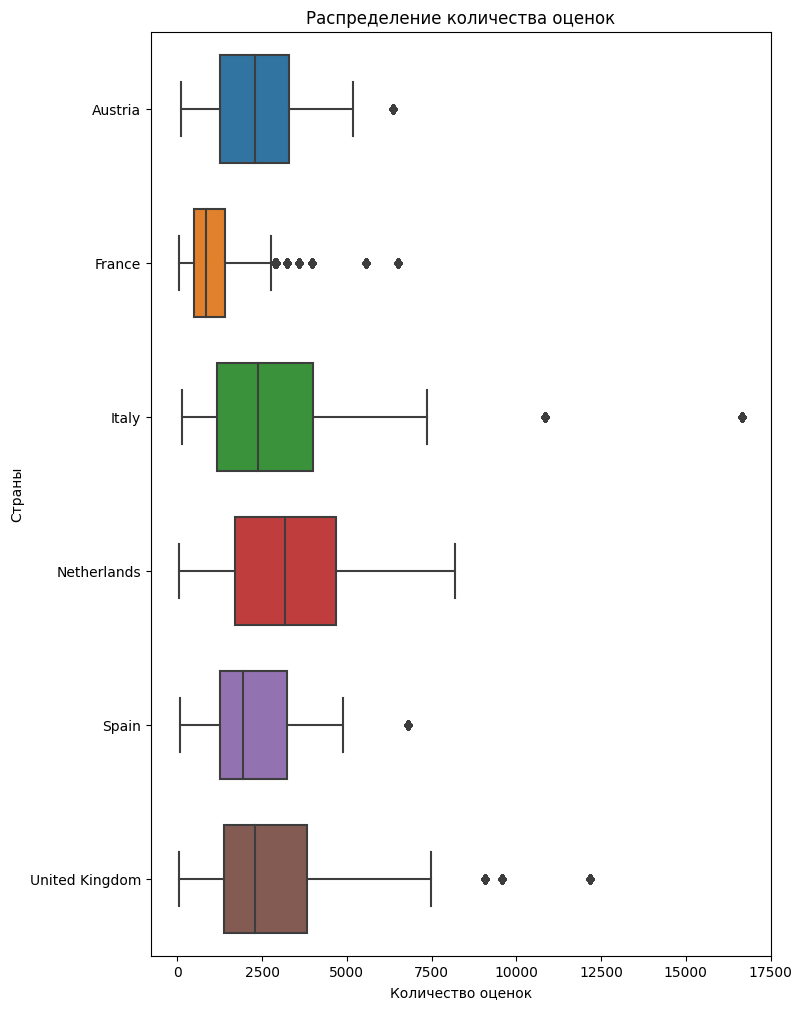

In [416]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 12))

country = sns.boxplot(
    data = data.sort_values(by='country', ascending=True),
    y = 'country',
    x = 'total_number_of_reviews',
    orient ='h',
    width = 0.7
)

country.set(xlabel='Количество оценок', ylabel='Страны', title='Распределение количества оценок')

<ul>При обучении модели можно будет попробовать следующие варианты:
<li>без сглаживания;</li>
<li>со сглаживанием для всего датасета;</li>
<li>со сглаживанием по странам.</li>
</ul>

Проведем сглаживание для всего датасета. При сглаживании выбросов применим метод межквартильного интервала.

In [417]:
q1 = data['total_number_of_reviews'].quantile([.25]).item()
q3 = data['total_number_of_reviews'].quantile([.75]).item()
iqr = q3 - q1
median = data['total_number_of_reviews'].median()
max_number = q3 + 1.5*iqr
min_number = q1 - 1.5*iqr
data['total_number_of_reviews'] = data['total_number_of_reviews'].apply(lambda x: x if x in pd.Interval(min_number, max_number) else min(max_number, max(min_number, x)))

Вариант сглаживания по отдельным странам.

In [418]:
# for country in data['country'].unique():
#     q1 = data[data['country'] == country]['total_number_of_reviews'].quantile([.25]).item()
#     q3 = data[data['country'] == country]['total_number_of_reviews'].quantile([.75]).item()
#     iqr = q3 - q1
#     median = data[data['country'] == country]['total_number_of_reviews'].median()
#     max_number = q3 + 1.5*iqr
#     min_number = q1 - 1.5*iqr
#     data['total_number_of_reviews'] = data.apply(lambda x: x['total_number_of_reviews'] if (x['total_number_of_reviews'] in pd.Interval(min_number, max_number)) or x['country'] != country else min(max_number, max(min_number, x['total_number_of_reviews'])),axis=1)

Еще раз выведем данные о распределении количества оценок.

[Text(0.5, 0, 'Количество оценок'),
 Text(0, 0.5, 'Страны'),
 Text(0.5, 1.0, 'Распределение количества оценок')]

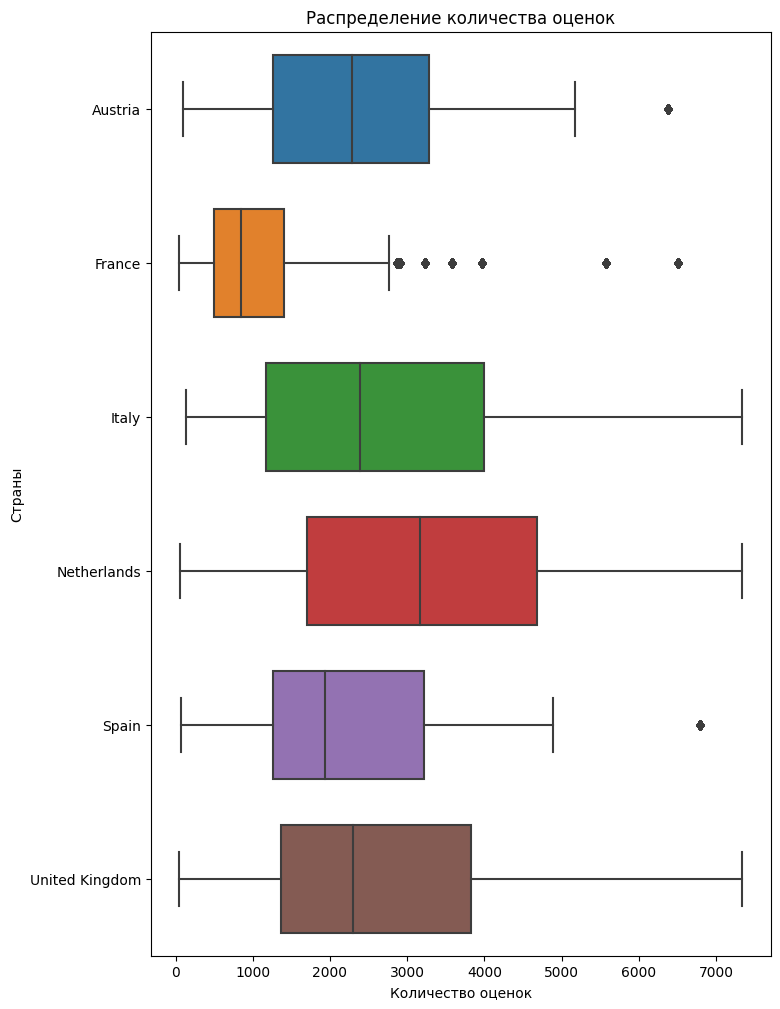

In [419]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 12))

country = sns.boxplot(
    data = data.sort_values(by='country', ascending=True),
    y = 'country',
    x = 'total_number_of_reviews',
    orient ='h',
    width = 0.7
)

country.set(xlabel='Количество оценок', ylabel='Страны', title='Распределение количества оценок')

Создадим тепловую карту корреляции признаков. Т.к. на этом этапе признаков получилось много, карту выведем для некоторых из них.

C:\Users\mmvvs\AppData\Local\Temp\ipykernel_15820\2566644900.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df[columns_list].corr(method=method).abs()


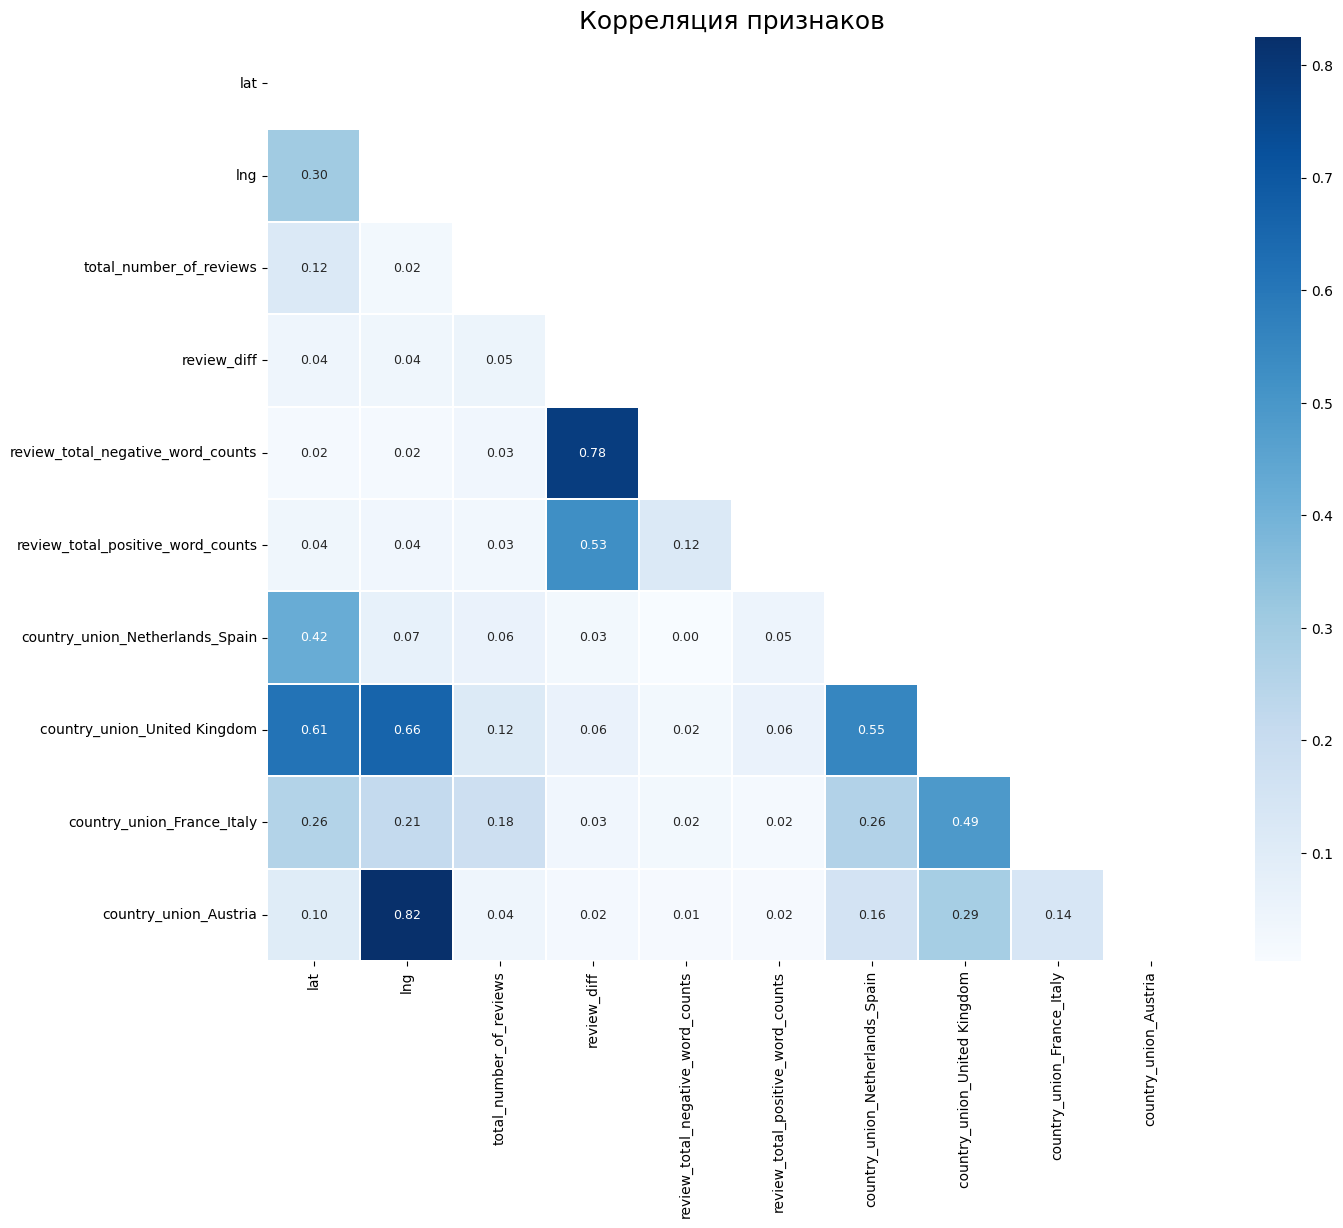

In [421]:
num_cols = [
     'lat'
     ,'lng'
     ,'total_number_of_reviews'
     ,'review_diff'
     ,'review_total_negative_word_counts'
     ,'review_total_positive_word_counts'
     ,'country_union_Netherlands_Spain'
     ,'country_union_United Kingdom'
     ,'country_union_France_Italy'
     ,'country_union_Austria'
     # ,'reviewer_nationality_0'
     # ,'reviewer_nationality_1'
     # ,'reviewer_nationality_2'
     # ,'reviewer_nationality_3'
     # ,'reviewer_nationality_4'
     # ,'reviewer_nationality_5'
     # ,'reviewer_nationality_6'
     # ,'additional_number_of_scoring'
     # ,'average_score'
     ,'negative_review'
     # ,'total_number_of_reviews'
     ,'positive_review'
     # ,'total_number_of_reviews_reviewer_has_given'
     # ,'tags'
     # ,'days_since_review'
     # ,'sample'
     # ,'reviewer_score'
     # ,'country'
     # ,'distance'
     # ,'review_year_month'
     # ,'review_weekday'
     # ,'review_day'
     # ,'country_reviewer'
     # ,'tags_list'
     # ,'tagn'
     # ,'night'
     # ,'Leisure_trip'
     # ,'Business_trip'
     # ,'Couple'
     # ,'Group'
     # ,'Family_with_older_children'
     # ,'Family_with_young_children'
     # ,'Solo_traveler'
     # ,'Submitted_from_a_mobile_device'
     # ,'room'
     # ,'room_0'
     # ,'room_1'
     # ,'room_2'
     # ,'room_3'
     # ,'room_4'
     # ,'room_5'
     # ,'room_6'
     # ,'neg_review_tokenized'
     # ,'pos_review_tokenized'
     # ,'nltk_n_neg'
     # ,'nltk_n_neu'
     # ,'nltk_n_pos'
     # ,'nltk_n_compound'
     # ,'tb_n_polarity'
     # ,'tb_n_subjectivity'
     # ,'afinn_n_score'
     # ,'country_reviewer'
]

show_corr(data,num_cols, 'Корреляция признаков')

In [422]:
mean = data['total_number_of_reviews'].mean().round()
min = data['total_number_of_reviews'].min()
max = data['total_number_of_reviews'].max()

data['total_number_of_reviews'] = (data['total_number_of_reviews'] - mean)/(max - min)

In [424]:
excess_columns = [
     'additional_number_of_scoring'
     , 'review_day'
     ,'Leisure_trip'
     ,'Couple'
     ,'Group'
     ,'Family_with_older_children'
     ,'Family_with_young_children'
     ,'Solo_traveler'
     ,'Submitted_from_a_mobile_device'
     ]


In [425]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515431 entries, 0 to 515430
Data columns (total 72 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   average_score                               515431 non-null  float64
 3   hotel_name                                  515431 non-null  object 
 4   reviewer_nationality                        515431 non-null  object 
 5   negative_review                             515431 non-null  object 
 6   review_total_negative_word_counts           515431 non-null  int64  
 7   total_number_of_reviews                     515431 non-null  float64
 8   positive_review                             515431 non-null  object 
 9   review_total_positive_word_counts           515431 non-null  int64  
 

None

In [426]:
display(data.columns)

Index(['hotel_address', 'additional_number_of_scoring', 'average_score',
       'hotel_name', 'reviewer_nationality', 'negative_review',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'positive_review', 'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'tags',
       'days_since_review', 'lat', 'lng', 'sample', 'reviewer_score',
       'country', 'distance', 'review_year_month', 'review_weekday',
       'review_day', 'country_reviewer', 'reviewer_nationality_0',
       'reviewer_nationality_1', 'reviewer_nationality_2',
       'reviewer_nationality_3', 'reviewer_nationality_4',
       'reviewer_nationality_5', 'reviewer_nationality_6', 'country_union',
       'country_union_France_Italy', 'country_union_Netherlands_Spain',
       'country_union_United Kingdom', 'country_union_Austria', 'tags_list',
       'tagn', 'night', 'Leisure_trip', 'Business_trip', 'Other_trip',
       'Couple', 'Group', 'Family_with_older_chi

In [427]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберем их и удалим

object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)
#data.drop(excess_columns, axis = 1, inplace=True)


In [428]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515431 entries, 0 to 515430
Data columns (total 59 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515431 non-null  int64  
 1   average_score                               515431 non-null  float64
 2   review_total_negative_word_counts           515431 non-null  int64  
 3   total_number_of_reviews                     515431 non-null  float64
 4   review_total_positive_word_counts           515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515431 non-null  int64  
 6   lat                                         515431 non-null  float64
 7   lng                                         515431 non-null  float64
 8   sample                                      515431 non-null  int64  
 9   reviewer_score                              515431 non-null  float64
 

In [429]:
display(data.head())

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score,...,tb_n_polarity,tb_n_subjectivity,afinn_n_score,nltk_p_neg,nltk_p_neu,nltk_p_pos,nltk_p_compound,tb_p_polarity,tb_p_subjectivity,afinn_p_score
0,904,8.1,52,0.646478,62,1,45.533137,9.171102,0,0.0,...,-0.05,0.35,5.0,0.000,0.671,0.329,0.9615,0.461364,0.643939,20.0
1,612,8.6,10,0.328172,0,7,52.385649,4.834443,0,0.0,...,0.00,0.00,-1.0,0.379,0.000,0.621,0.3400,-0.113636,0.545455,1.0
2,46,8.3,3,-0.311318,5,15,41.393192,2.161520,0,0.0,...,0.00,0.00,0.0,0.000,0.260,0.740,0.6908,0.600000,1.000000,3.0
3,241,9.1,0,-0.147986,27,9,45.479888,9.196298,0,0.0,...,0.15,0.40,-3.0,0.000,0.621,0.379,0.9153,0.525000,0.650000,9.0
4,834,9.1,0,0.282817,7,2,52.370545,4.888644,0,0.0,...,0.15,0.40,-3.0,0.000,0.230,0.770,0.7717,0.500000,0.750000,3.0


In [430]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [431]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [432]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 58), (386496, 58), (386496, 57), (309196, 57), (77300, 57))

In [433]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [434]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [435]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.5s finished


In [436]:
# Пишем свою функцию Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [437]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))


MAE: 0.8621667011642946
MAPE: 12.31743357351345


Submission:

In [438]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,reviewer_score,distance,...,tb_n_polarity,tb_n_subjectivity,afinn_n_score,nltk_p_neg,nltk_p_neu,nltk_p_pos,nltk_p_compound,tb_p_polarity,tb_p_subjectivity,afinn_p_score
43490,227,8.6,19,-0.226774,53,1,51.500198,-0.179536,0.0,0.163370,...,0.500000,0.700000,3.0,0.000,0.748,0.252,0.9349,0.291667,0.545833,9.0
112424,452,7.6,0,-0.008358,53,5,51.511945,-0.179939,0.0,0.162355,...,0.150000,0.400000,-3.0,0.079,0.803,0.118,0.4482,0.197449,0.478061,1.0
99375,765,8.4,6,0.282680,2,7,52.372707,4.894366,0.0,0.016357,...,-0.400000,0.600000,-2.0,0.000,1.000,0.000,0.0000,0.000000,0.000000,0.0
1813,930,8.9,54,0.029186,13,4,51.507271,-0.021121,0.0,0.327532,...,-0.202778,0.644444,-1.0,0.000,0.709,0.291,0.5719,0.500000,0.750000,3.0
28523,269,7.9,2,-0.244999,2,1,51.573106,-0.223333,0.0,0.437523,...,0.000000,0.000000,0.0,0.000,1.000,0.000,0.0000,0.000000,0.000000,0.0
26778,995,8.1,16,0.164840,3,2,51.504348,-0.033444,0.0,0.290029,...,0.000000,0.000000,-1.0,0.000,1.000,0.000,0.0000,0.000000,0.000000,0.0
33398,237,8.4,28,-0.060839,23,1,52.310118,4.947292,0.0,0.950180,...,0.455000,0.655000,11.0,0.150,0.727,0.123,-0.1531,-0.357143,0.595238,0.0
106130,493,8.6,24,0.033160,21,22,52.376418,4.900220,0.0,0.077340,...,0.433333,0.433333,5.0,0.000,0.602,0.398,0.8720,0.687500,0.400000,7.0
107697,31,8.4,13,-0.329542,29,2,48.874607,2.316720,0.0,0.570303,...,0.000000,0.000000,0.0,0.000,0.559,0.441,0.9485,0.330102,0.655102,10.0
50337,130,8.2,12,-0.230748,0,1,48.205097,16.377093,0.0,0.043296,...,0.000000,0.000000,0.0,0.379,0.000,0.621,0.3400,-0.113636,0.545455,1.0


In [439]:
# Удаляем целевой признак из тестовой выборки:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [440]:
display(sample_submission.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


None

In [441]:
display(test_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128935 entries, 0 to 128934
Data columns (total 57 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                128935 non-null  int64  
 1   average_score                               128935 non-null  float64
 2   review_total_negative_word_counts           128935 non-null  int64  
 3   total_number_of_reviews                     128935 non-null  float64
 4   review_total_positive_word_counts           128935 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  128935 non-null  int64  
 6   lat                                         128935 non-null  float64
 7   lng                                         128935 non-null  float64
 8   distance                                    128935 non-null  float64
 9   review_year_month                           128935 non-null  int64  
 

None

In [442]:
# Сохраняем предсказание модели в сабмишн:
sample_submission['reviewer_score'] = model.predict(test_data)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.0s finished


In [443]:
# Сохраняем сабмишн в csv-файл:
sample_submission['reviewer_score'] = sample_submission['reviewer_score'].apply(lambda x: round(x,1))
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head()

,reviewer_score,id
0,8.4,488440
1,7.6,274649
2,8.9,374688
3,9.7,404352
4,9.5,451596


<AxesSubplot: >

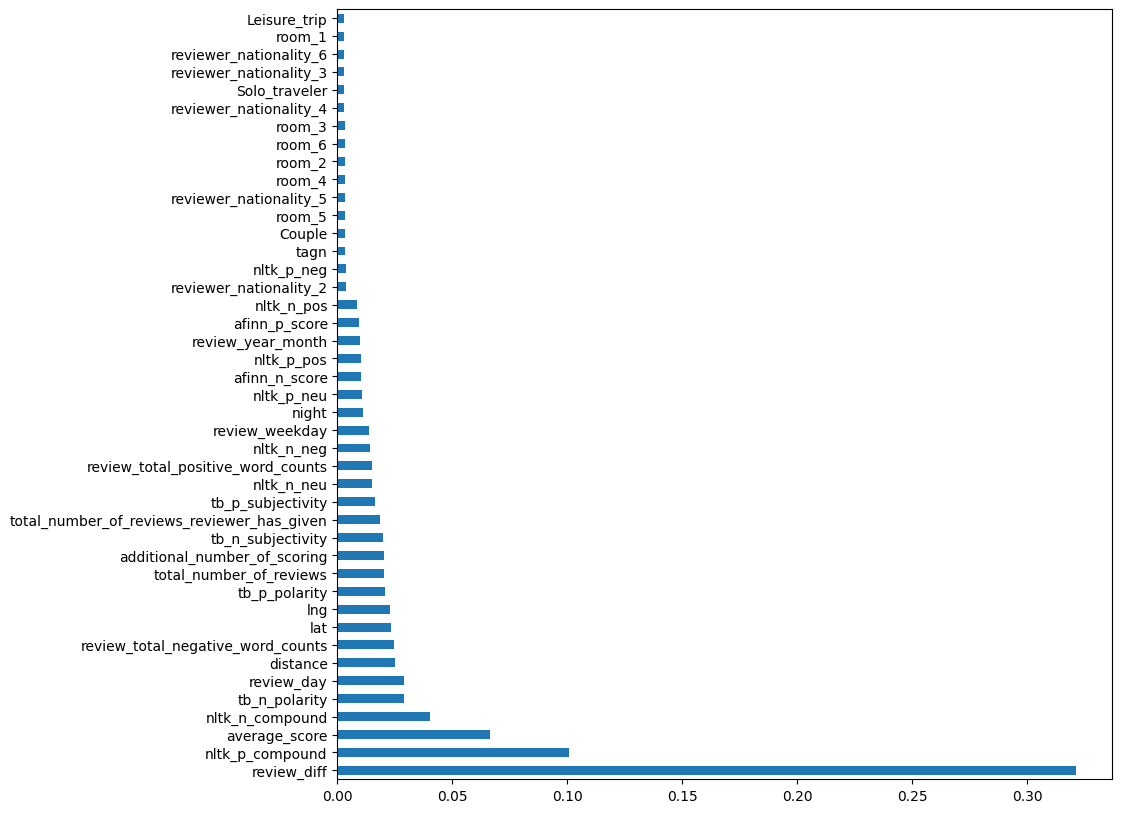

In [444]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(43).plot(kind='barh')